# **Project 2 Data Management: Airline On-Time Performance in 2007**

- For this project, the **Data Expo 2009: Airline On Time Data** retrieved from [kaggle](https://www.kaggle.com/datasets/wenxingdi/data-expo-2009-airline-on-time-data/data?select=1993.csv) will be used for analysis to identify delay patterns, delay factors, cancellation flight analysis and problematic routes. The dataset provides flights information from 1987 until 2008. For this project, the dataset from the **year 2007** will be used for this analysis.

- There are four datasets that will be used for this analysis such as **2007.csv**, **airports.csv**, **plane-data.csv** and **carriers.csv**. Further information regarding on these datasets was mentioned in below:

***Table 1*: Flight Data `data2007`**

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| Year                  | 1987–2008                                                                   |int          |
| Month                 | 12–Jan                                                                      |string       |
| DayofMonth            | 31–Jan                                                                      |string       |
| DayOfWeek             | 1 (Monday) – 7 (Sunday)                                                     |int          |
| DepTime               | actual departure time (local, hhmm)                                         |int          |
| CRSDepTime            | scheduled departure time (local, hhmm)                                      |int          |
| ArrTime               | actual arrival time (local, hhmm)                                           |int          |
| CRSArrTime            | scheduled arrival time (local, hhmm)                                        |int          |
| UniqueCarrier         | unique carrier code                                                         |string       |
| FlightNum             | flight number                                                               |int          |
| TailNum               | plane tail number                                                           |string       |
| ActualElapsedTime     | in minutes                                                                  |int          |
| CRSElapsedTime        | in minutes                                                                  |int          |
| AirTime               | in minutes                                                                  |int          |
| ArrDelay              | arrival delay, in minutes                                                   |int          |
| DepDelay              | departure delay, in minutes                                                 |int          |
| Origin                | origin IATA airport code                                                    |string       |
| Dest                  | destination IATA airport code                                               |string       |
| Distance              | in miles                                                                    |int          |
| TaxiIn                | taxi in time, in minutes                                                    |int          |
| TaxiOut               | taxi out time, in minutes                                                   |int          |
| Cancelled             | was the flight cancelled?                                                   |bool         |
| CancellationCode      | reason for cancellation (A = carrier, B = weather, C = NAS, D = security)   |string       |
| Diverted              | 1 = yes, 0 = no                                                             |bool         |
| CarrierDelay          | in minutes                                                                  |int          |
| WeatherDelay          | in minutes                                                                  |int          |
| NASDelay              | in minutes                                                                  |int          |
| SecurityDelay         | in minutes                                                                  |int          |
| LateAircraftDelay     | in minutes                                                                  |int          |

***Table 2*: Airport Data `airports`**

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| airport                  | Airport Name                                                             |string       |
| city                     | Airport City                                                             |string       |
| country                  | Airport Country                                                          |string       |
| iata                     | Airport Code                                                             |string       |
| lat                      | Aiport Latitude                                                          |float        |
| long                     | Airport Longitude                                                        |float        |
| state                    | Airport State                                                            |string       |


***Table 3*: Plane Data `plane_data`**

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| tailnum               | Aircraft Tail Number                                                        |string       |
| type                  | Usage Type                                                                  |string       |
| manufacturer          | Manufacturer Company                                                        |string       |
| issue_date            | Date Start Operating                                                        |string       |
| model                 | Aircraft Model                                                              |string       |
| status                | Status                                                                      |string       |
| aircraft_type         | Aircraft Type                                                               |string       |
| engine_type           | Engine Type                                                                 |string       |
| year                  | Manufacture Year                                                            |string       |

***Table 4*: Carrier Data / Airline `carriers`**

| **Attribute**         | **Description**                                                             |**Type**     |
|-----------------------|:----------------------------------------------------------------------------|:-----------:|
| code                  | Carrier Code                                                                |string       |
| description           | Carrier Name                                                                |string       |

# **1.0 Import Dataset into HDFS and Hive Database**

1. The dataset was downloaded from the website kaggle as csv format. 

2. The dataset was pushed into virtual machine using the given script to run in command prompt (cmd)
>```batch
>pscp -P 2222 "C:\Users\User\OneDrive\Desktop\Data Management\Assignment 2\*.csv" maria_dev@127.0.0.1:home/maria_dev
>```
3. Then, the dataset was uploaded into HIVE database using PUTTY
>```batch
>hadoop fs -copyFromLocal *.csv user/luqman/assignment2_DM/data/
>```
4. The dataset was uploaded to HIVE database using HIVE 2.0 interface

# **2.0 Load Libraries and Create Function** 

In [1]:
# Import libraries
# Load libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from impala.dbapi import connect


# Set matplotlib style
plt.style.use('ggplot')

# Ignore warnings for cleaner coding
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create a connection to the Hive database using Impala
cursor = connect(
    host='127.0.0.1',
    port = 10000,
    user = 'maria_dev',
    database = 'airlines',
    auth_mechanism = 'PLAIN'
).cursor()

# Execute a query to show all tables in the database    
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('airports',), ('carriers',), ('data2007',), ('plane',)]


**The function below was created for reproducibility.**

In [3]:
# Wrap the data pulling process in a function for reusability
def pull_data(command):
    conn = connect(
        host='127.0.0.1',
        port=10000,
        user='maria_dev',
        database='airlines',
        auth_mechanism='PLAIN'
    )
    cursor = conn.cursor()
    cursor.execute(command)
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    df.columns = df.columns.str.replace('^.*\.', '', regex=True)
    return df

# **3.0 Data Analysis**

## **3.1 Delay Patterns**

### **3.1.1 Time of Day Delay**

- In this section demonstrated the analysis of arrival flight delays and departure flight delays in terms of time of day such as morning, afternoon, evening and night. 

In [4]:
query1 = '''
WITH TimeGrouped AS (
  SELECT 
    CASE 
      WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
      WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
      WHEN CRSDepTime BETWEEN 1700 AND 2059 THEN 'Evening'
      ELSE 'Night'
    END AS TimeOfDay,
    DepDelay,
    ArrDelay
  FROM data2007
  WHERE DepDelay IS NOT NULL 
    AND ArrDelay IS NOT NULL 
    AND Cancelled = 0
)

SELECT 
  TimeOfDay,
  AVG(DepDelay) AS AvgDepartureDelay,
  AVG(ArrDelay) AS AvgArrivalDelay
FROM TimeGrouped
GROUP BY TimeOfDay
'''

df1 = pull_data(query1)
df1


,timeofday,avgdeparturedelay,avgarrivaldelay
0,Afternoon,13.255730,12.390916
1,Morning,5.335252,4.182838
2,Night,15.043627,13.174089
3,Evening,18.859753,17.397705


In [5]:
# Sort time of day by custom order
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df1 = df1.groupby('timeofday', observed=True).agg(
    avgarrivaldelay=('avgarrivaldelay', 'mean'),
    avgdeparturedelay=('avgdeparturedelay', 'mean')
).reindex(time_order)

df1

,avgarrivaldelay,avgdeparturedelay
timeofday,,
Morning,4.182838,5.335252
Afternoon,12.390916,13.255730
Evening,17.397705,18.859753
Night,13.174089,15.043627


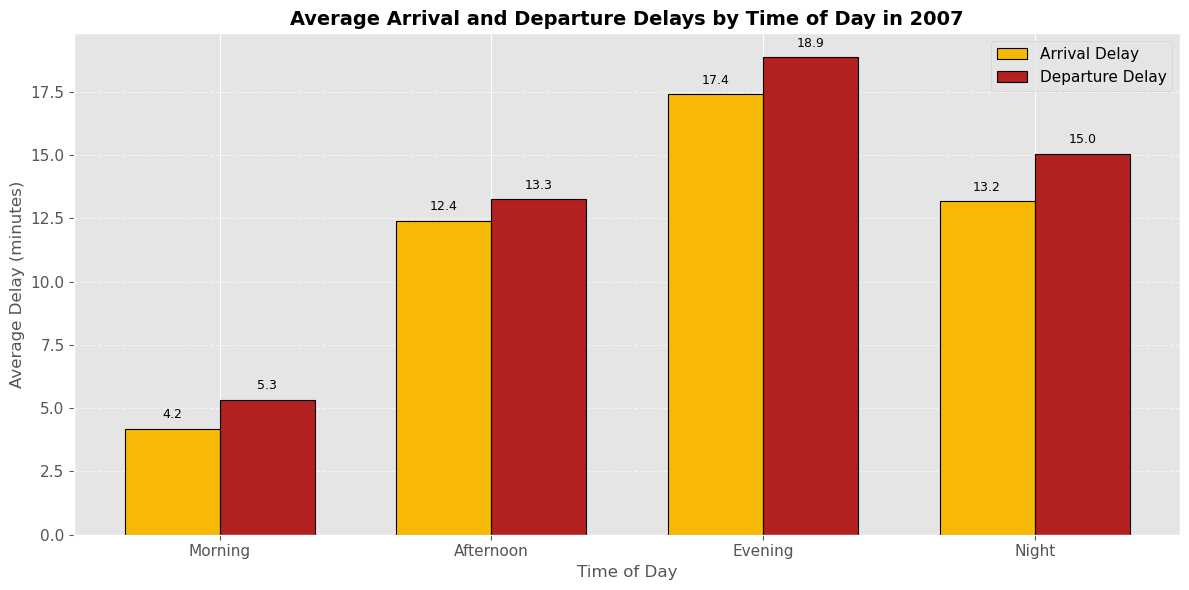

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the time order
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
x = np.arange(len(time_order))
width = 0.35

# Create figure
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')  # clean style

# Plot the bars
bars1 = plt.bar(x - width/2, df1['avgarrivaldelay'], width, label='Arrival Delay', color="#F8B806", edgecolor='black', linewidth=0.8)
bars2 = plt.bar(x + width/2, df1['avgdeparturedelay'], width, label='Departure Delay', color="#B22020", edgecolor='black', linewidth=0.8)

# Add value labels on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f'{yval:.1f}', ha='center', va='bottom', fontsize=9)

# Customize labels and title
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.title('Average Arrival and Departure Delays by Time of Day in 2007', fontsize=14, fontweight='bold')
plt.xticks(x, time_order, fontsize=11)
plt.yticks(fontsize=11)

# Add grid only on y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=11)

# Tight layout and show
plt.tight_layout()
plt.show()


- Based on the figure above, it is evident that flights scheduled in the morning experience the lowest average delays. Specifically, the average arrival delay during the morning is approximately 4.2 minutes whereas the departure delay is around 5.3 minutes. In comparison, other times of the day such as afternoon, evening and night show progressively higher delays with evening flights experiencing the highest average delays which is around 17.4 minutes for arrivals and 18.9 minutes for departures. This pattern suggests that flights tend to be more punctual earlier in the day whereas delays increase as the day progresses.

- The observed trend aligns with existing literature which indicates that morning flights are generally more reliable in terms of on-time performance. According to the U.S. Department of Transportation, delays are less frequent in the early part of the day because flight schedules are less affected by cascading disruptions that accumulate throughout the afternoon and evening (Bureau of Transportation Statistics, 2023). Additionally, previous findings analyzing airline operational data have shown that as air traffic intensifies and weather conditions fluctuate, delays tend to compound and worsen, particularly in the later hours of the day (Ahmed, Alam, & Rahman, 2019). Therefore, the figure strongly supports the conclusion that morning is the best time of day to fly in order to minimize the risk of delays.

**References:**

Ahmed, F., Alam, M., & Rahman, M. (2019). Analyzing flight delay patterns and performance: A case study of U.S. domestic flights. Journal of Air Transport Management, 75, 35–44. https://doi.org/10.1016/j.jairtraman.2019.01.001

Bureau of Transportation Statistics. (2023). Airline on-time statistics and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp



### **3.1.2 Day of Week**

- In this sub-section will be discussing better on-time performance on the arrival flight delays and departure flight delays in terms day of week (Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday) 

In [7]:
query2 = '''
SELECT DayOfWeek, 
       AVG(DepDelay) AS AvgDeparturedelay,
       AVG(ArrDelay) AS AvgArrivalDelay
FROM data2007
WHERE DepDelay IS NOT NULL 
    AND ArrDelay IS NOT NULL 
    AND Cancelled = 0
GROUP BY DayOfWeek
'''

df2 = pull_data(query2)
df2

,dayofweek,avgdeparturedelay,avgarrivaldelay
0,1,11.865884,10.513503
1,6,8.965287,5.846600
2,7,11.949764,10.329577
3,2,9.357214,8.263684
4,3,10.641332,9.962944
5,4,12.840758,12.685980
6,5,13.536223,13.067675


In [8]:
# Map and sort the days of the week

df2 = df2.sort_values('dayofweek')
df2['dayofweek'] = df2['dayofweek'].map({1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})
df2

,dayofweek,avgdeparturedelay,avgarrivaldelay
0,Monday,11.865884,10.513503
3,Tuesday,9.357214,8.263684
4,Wednesday,10.641332,9.962944
5,Thursday,12.840758,12.685980
6,Friday,13.536223,13.067675
1,Saturday,8.965287,5.846600
2,Sunday,11.949764,10.329577


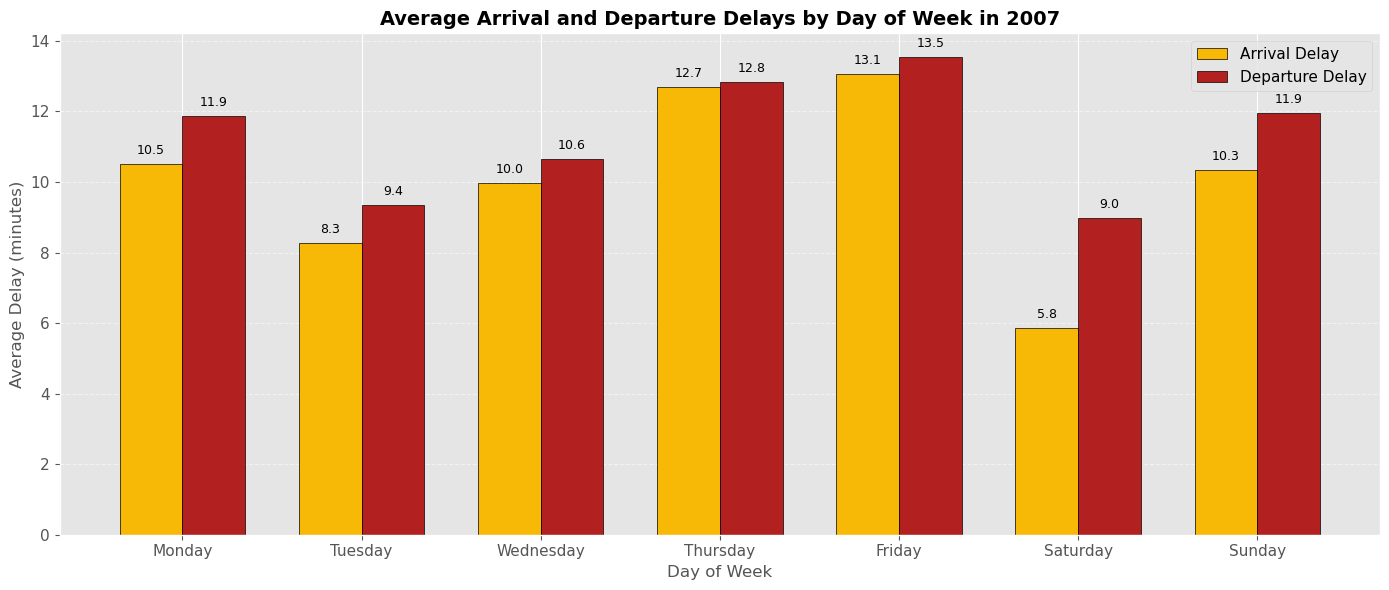

In [9]:
# Sort days properly if not already
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df2['dayofweek'] = pd.Categorical(df2['dayofweek'], categories=day_order, ordered=True)
df2 = df2.sort_values('dayofweek')

# Setup bar positions
x = np.arange(len(df2['dayofweek']))
width = 0.35

# Create figure with improved style
plt.style.use('ggplot')
plt.figure(figsize=(14, 6))

# Plot bars with better colors and edge contrast
bars1 = plt.bar(x - width/2, df2['avgarrivaldelay'], width, label='Arrival Delay',
                color="#F8B806", edgecolor='black')
bars2 = plt.bar(x + width/2, df2['avgdeparturedelay'], width, label='Departure Delay',
                color="#B22020", edgecolor='black')

# Add value labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=9)

# Labels and aesthetics
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.title('Average Arrival and Departure Delays by Day of Week in 2007', fontsize=14, fontweight='bold')
plt.xticks(x, df2['dayofweek'], fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

- Based on figure above shown, the day that depicts the best on-time performance is Saturday followed by Tuesday. Specifically, the average arrival delay on Saturday is 5.8 minutes which is significantly lower than on other days. The departure delay on Saturday is also relatively low at 9.0 minutes making it the most punctual day overall. In contrast, Friday experiences the highest average delays with arrival delays at 13.1 minutes and departure delays reaching 13.5 minutes. This figure indicate that delays tend to accumulate toward the end of the workweek, peaking on Friday before dropping sharply on Saturday.

- This trend can be explained by differences in flight volume and air traffic congestion. Fridays are known for higher passenger demand due to end-of-week travel which often leads to more frequent delays as airports and airspace become congested (Federal Aviation Administration [FAA], 2022). On the other hand, Saturdays typically have lower air traffic which contributes to smoother operations and fewer cascading delays from earlier flights. The U.S. Department of Transportation also reports that weekends particularly Saturdays often see improved on-time performance due to reduced operational stress across airlines and airports (Bureau of Transportation Statistics, 2023). Therefore, the figure supports the conclusion that flights scheduled on Saturdays and Tuesdays tend to be more reliable while those on Fridays and Thursdays are more prone to delays.

**References:**

Bureau of Transportation Statistics. (2023). Airline on-time statistics and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

Federal Aviation Administration. (2022). NextGen performance snapshot: Factors impacting flight delays. https://www.faa.gov/nextgen/snapshots/DelayCauses

### **3.1.2 Monthly Delay**

- In this sub-section will be discussing which months or season that shows flight most likely to be on time across the year.

In [10]:
query3 = ''' 
SELECT Month, 
       AVG(DepDelay) AS AvgDeparturedelay,
       AVG(ArrDelay) AS AvgArrivalDelay
FROM data2007
WHERE DepDelay IS NOT NULL 
    AND ArrDelay IS NOT NULL 
    AND Cancelled = 0
GROUP BY Month
'''
df3 = pull_data(query3)
df3

,month,avgdeparturedelay,avgarrivaldelay
0,1,10.252986,9.162152
1,11,7.426760,4.793344
2,12,16.164563,16.213714
3,2,13.982618,13.519795
4,4,10.058320,8.516230
5,7,14.771436,14.107680
6,9,6.141357,3.749498
7,10,7.942427,6.508259
8,3,11.791911,10.084908
9,5,8.305957,7.037889


In [11]:
# Ensure 'month' column is integer
df3['month'] = df3['month'].astype(int)

# Define month-to-season mapping
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the mapping
df3['season'] = df3['month'].apply(month_to_season)

# Group and calculate average delays
df_season = df3.groupby('season', as_index=False)[['avgdeparturedelay', 'avgarrivaldelay']].mean()

# Sort by departure delay (optional)
df_season = df_season.sort_values(by='avgdeparturedelay')

df_season.head()


,season,avgdeparturedelay,avgarrivaldelay
0,Fall,7.170182,5.017034
1,Spring,10.052063,8.546342
3,Winter,13.466722,12.965220
2,Summer,14.792736,14.286247


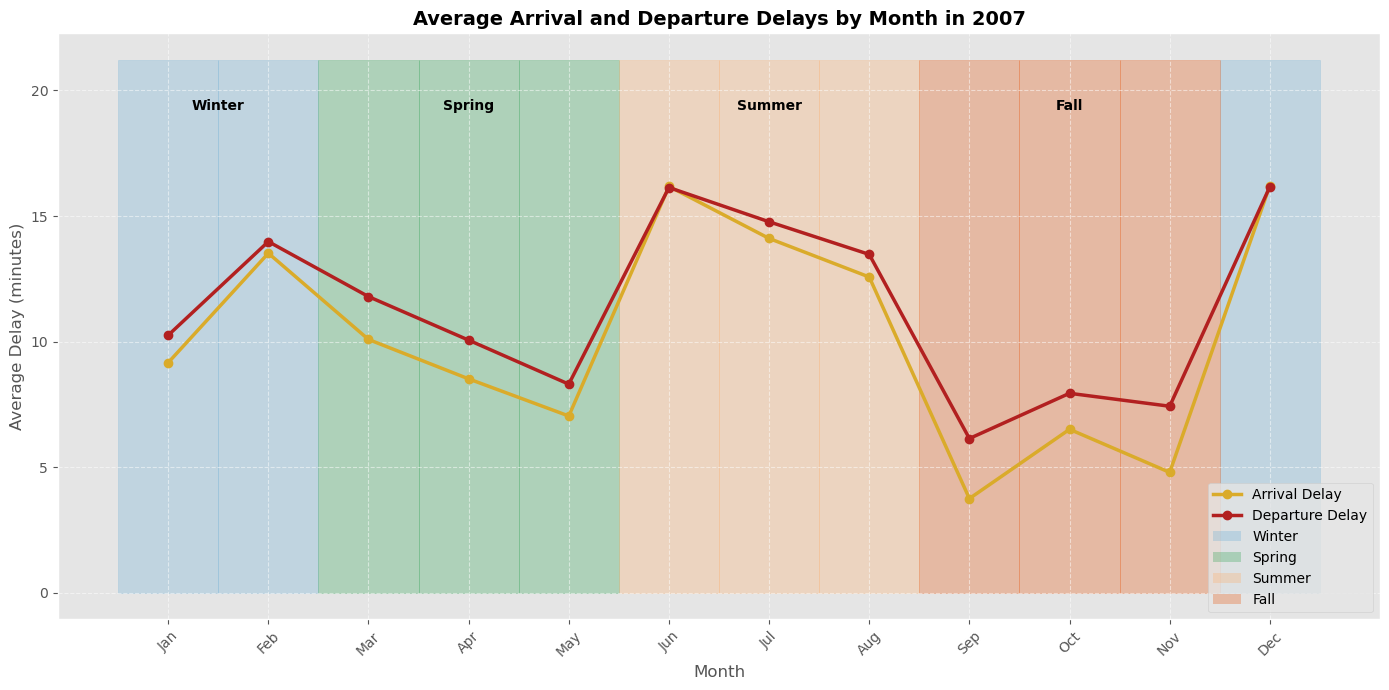

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Ensure month is integer
df3['month'] = df3['month'].astype(int)

# Re-assign season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df3['season'] = df3['month'].apply(month_to_season)
df3 = df3.sort_values('month')

# ✨ Updated plot style
plt.figure(figsize=(14, 7))
plt.style.use('ggplot')

# New color palette
arrival_color = "#DAAB2A"     # blue
departure_color = "#B22020"   # orange

plt.plot(df3['month'], df3['avgarrivaldelay'], marker='o', label='Arrival Delay', color=arrival_color, linewidth=2.5)
plt.plot(df3['month'], df3['avgdeparturedelay'], marker='o', label='Departure Delay', color=departure_color, linewidth=2.5)

# 🟨 Updated season color palette
season_colors = {
    'Winter': '#6baed6',  # deeper blue
    'Spring': '#31a354',  # lush green
    'Summer': '#fdae6b',  # bright orange-yellow
    'Fall':   '#e6550d'   # deep orange
}

legend_elements = []
max_y = max(df3['avgarrivaldelay'].max(), df3['avgdeparturedelay'].max()) + 5

# Fill season backgrounds
for season in season_colors.keys():
    months_in_season = df3[df3['season'] == season]['month'].tolist()
    for m in months_in_season:
        x_rect = [m - 0.5, m + 0.5, m + 0.5, m - 0.5]
        y_rect = [0, 0, max_y, max_y]
        plt.fill(x_rect, y_rect, color=season_colors[season], alpha=0.3, zorder=0)
    
    legend_elements.append(Patch(facecolor=season_colors[season], alpha=0.3, label=season))

# Combine with line legend
line_elements = plt.gca().get_legend_handles_labels()[0]
legend_elements = line_elements + legend_elements

# Add seasonal labels
plt.text(1.5, max_y - 2, 'Winter', ha='center', fontsize=10, fontweight='bold')
plt.text(4, max_y - 2, 'Spring', ha='center', fontsize=10, fontweight='bold')
plt.text(7, max_y - 2, 'Summer', ha='center', fontsize=10, fontweight='bold')
plt.text(10, max_y - 2, 'Fall', ha='center', fontsize=10, fontweight='bold')

# Labels and formatting
plt.title('Average Arrival and Departure Delays by Month in 2007', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.xticks(df3['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



- Based on the figure above, it was revealed that flights are most likely to be on time during the months of September, October and November which fall under the Fall season. In particular, September shows the lowest average delays with arrival delays around 3.8 minutes and departure delays approximately 6.1 minutes. Similarly, October and November maintain relatively low delay averages compared to other times of the year. This trend contrasts sharply with June, July and December where delays are at their highest with departure delays exceeding 16 minutes in June and December and arrival delays also peaking during those months.

- The seasonal pattern reveals that Fall offers the most favorable conditions for on-time performance whereas Summer and Winter tend to experience higher delays. This observation aligns with findings from transportation research which identify summer travel as particularly vulnerable to delays due to increased passenger volume, weather disruptions and airport congestion (Bureau of Transportation Statistics, 2023). Likewise, winter months such as December are prone to delays caused by snowstorms, ice, and de-icing operations which can significantly impact departure schedules (Federal Aviation Administration, 2022). In contrast, the Fall season typically has milder weather and lower travel demand leading to more efficient flight operations and reduced cumulative delays throughout the day.

- In conclusion, the data in the figure supports that flights are most likely to be on time during the Fall months of September through November whereas June and December represent periods of the highest delay risk.

**References:**

Bureau of Transportation Statistics. (2023). Airline on-time statistics and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

Federal Aviation Administration. (2022). NextGen performance snapshot: Factors impacting flight delays. https://www.faa.gov/nextgen/snapshots/DelayCauses



## **3.2 Delay Factors**

- In this section will demonstrate the factors that contributes to flight delays based on the delay categories provided in the dataset and also quantify the impact of each factor (in minutes of delay and percentage of total delays). 

In [13]:
query4 = '''
SELECT
  'Carrier' AS Delay_Type,
  SUM(CarrierDelay) AS Total_Delay_Minutes,
  AVG(CarrierDelay) AS Average_Delay_Minutes,
  SUM(CASE WHEN CarrierDelay > 0 THEN 1 ELSE 0 END) AS Delay_Incidents
FROM data2007
WHERE Cancelled = 0

UNION ALL

SELECT
  'Weather' AS Delay_Type,
  SUM(WeatherDelay) AS Total_Delay_Minutes,
  AVG(WeatherDelay) AS Average_Delay_Minutes,
  SUM(CASE WHEN WeatherDelay > 0 THEN 1 ELSE 0 END) AS Delay_Incidents
FROM data2007
WHERE Cancelled = 0

UNION ALL

SELECT
  'NAS' AS Delay_Type,
  SUM(NASDelay) AS Total_Delay_Minutes,
  AVG(NASDelay) AS Average_Delay_Minutes,
  SUM(CASE WHEN NASDelay > 0 THEN 1 ELSE 0 END) AS Delay_Incidents
FROM data2007
WHERE Cancelled = 0

UNION ALL

SELECT
  'Security' AS Delay_Type,
  SUM(SecurityDelay) AS Total_Delay_Minutes,
  AVG(SecurityDelay) AS Average_Delay_Minutes,
  SUM(CASE WHEN SecurityDelay > 0 THEN 1 ELSE 0 END) AS Delay_Incidents
FROM data2007
WHERE Cancelled = 0

UNION ALL

SELECT
  'Late Aircraft' AS Delay_Type,
  SUM(LateAircraftDelay) AS Total_Delay_Minutes,
  AVG(LateAircraftDelay) AS Average_Delay_Minutes,
  SUM(CASE WHEN LateAircraftDelay > 0 THEN 1 ELSE 0 END) AS Delay_Incidents
FROM data2007
WHERE Cancelled = 0
'''

df4 = pull_data(query4)
df4

,delay_type,total_delay_minutes,average_delay_minutes,delay_incidents
0,Carrier,28808434,3.950437,814922
1,Weather,5739649,0.787065,127849
2,NAS,28200746,3.867106,1044257
3,Security,176906,0.024259,9269
4,Late Aircraft,38004942,5.211534,838599


   incident_percent  average_delay_minutes    delay_type
0         36.835813               3.867106           NAS
1         29.581297               5.211534  LateAircraft
2         28.746099               3.950437       Carrier
3          4.509830               0.787065       Weather
4          0.326961               0.024259      Security


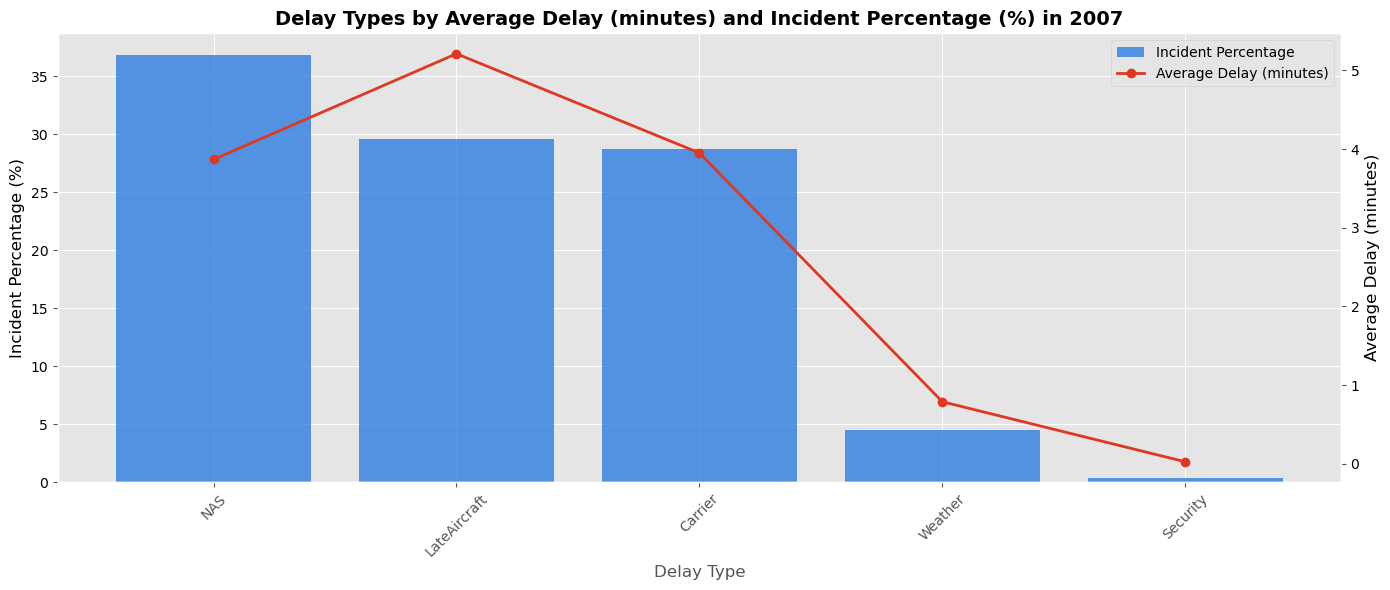

In [14]:
# Prepare data
df_plot = df4.copy()
df_plot['incident_percent'] = (df_plot['delay_incidents'] / df_plot['delay_incidents'].sum()) * 100
df_plot['delay_type'] = df_plot['delay_type'].str.replace(' ', '').str.replace('_', '')

# Sort by incident percentage
df_plot = df_plot.sort_values(by='incident_percent', ascending=False).reset_index(drop=True)

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

x = range(len(df_plot))
labels = df_plot['delay_type']

# Bar chart
bar_color = "#2F7CE0"
line_color = "#E03721"
bars = ax1.bar(x, df_plot['incident_percent'], color=bar_color, alpha=0.8, label='Incident Percentage')

# Primary Y-axis
ax1.set_xlabel('Delay Type')
ax1.set_ylabel('Incident Percentage (%)', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')  
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)

# Secondary Y-axis
ax2 = ax1.twinx()
line = ax2.plot(x, df_plot['average_delay_minutes'], color=line_color, marker='o', linewidth=2, label='Average Delay (minutes)')
ax2.set_ylabel('Average Delay (minutes)', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')  # Black Y2 axis
ax2.grid(False) 

# Title and combined legend
plt.title('Delay Types by Average Delay (minutes) and Incident Percentage (%) in 2007', fontsize=14, fontweight='bold')
lines_labels = [bars, line[0]]
labels_combined = [l.get_label() for l in lines_labels]
ax1.legend(lines_labels, labels_combined, loc='upper right')

print(df_plot[['incident_percent','average_delay_minutes','delay_type']])
plt.tight_layout()
plt.show()

- According to the figure above, the top contributing factors to flight delays can be identified and ranked by examining both the frequency of delay incidents and the average duration of each delay type. The most significant contributor is the National Aviation System (NAS) delay which accounts for approximately 37 percent of all delay incidents. Its average delay per incident is moderate at around 3.9 minutes but its high frequency makes it the most influential factor overall.

- The second highest contributor is Late Aircraft Delay, responsible for roughly 30 percent of delay incidents. It has the longest average delay duration about 5.2 minutes indicating that while it is slightly less frequent than NAS delays, its operational impact is more severe. Carrier Delays follow closely accounting for approximately 29 percent of delay incidents with an average delay of nearly 4 minutes. These delays are related to airline-specific issues such as baggage handling, maintenance or crew availability.

- In comparison, Weather and Security delays have relatively minor effects. Weather delays constitute only about 4.5 percent of all incidents and typically cause an average delay of less than one minute. Security delays are the least impactful making up just 0.3 percent of incidents with an almost negligible delay time. Although weather and security are often emphasized in public discussions, the data clearly shows that operational and system-level factors like NAS, Late Aircraft, and Carrier delays are the primary sources of disruption.

- These findings are consistent with national transportation data. According to the U.S. Department of Transportation, NAS and airline operational delays remain the leading causes of flight disruptions in the United States. Furthermore, research shows that delays caused by late aircraft tend to propagate throughout the day affecting subsequent flight schedules and increasing cumulative delays (Ahmed, Alam, & Rahman, 2019). Based on this analysis, the most critical areas for improvement in delay management are NAS efficiency, on-time aircraft turnaround and carrier operational planning.

**References:**

Ahmed, F., Alam, M., & Rahman, M. (2019). Analyzing flight delay patterns and performance: A case study of U.S. domestic flights. Journal of Air Transport Management, 75, 35–44. https://doi.org/10.1016/j.jairtraman.2019.01.001

Bureau of Transportation Statistics. (2023). Airline on-time statistics and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp


## **3.3 Cancellation Analysis**

- In this sub-section will be discussing on the primary reasons for flight cancellations

In [15]:
query5 = '''
SELECT 
  CASE 
    WHEN CancellationCode = 'A' THEN 'Carrier'
    WHEN CancellationCode = 'B' THEN 'Weather'
    WHEN CancellationCode = 'C' THEN 'NAS'
    WHEN CancellationCode = 'D' THEN 'Security'
    ELSE 'Unknown'
  END AS Reason,
  COUNT(*) AS Cancelled_Flights
FROM data2007
WHERE Cancelled = 1
GROUP BY CancellationCode
ORDER BY Cancelled_Flights DESC
'''

df6 = pull_data(query5)
df6

,reason,cancelled_flights
0,Carrier,66779
1,Weather,61935
2,NAS,31995
3,Security,39


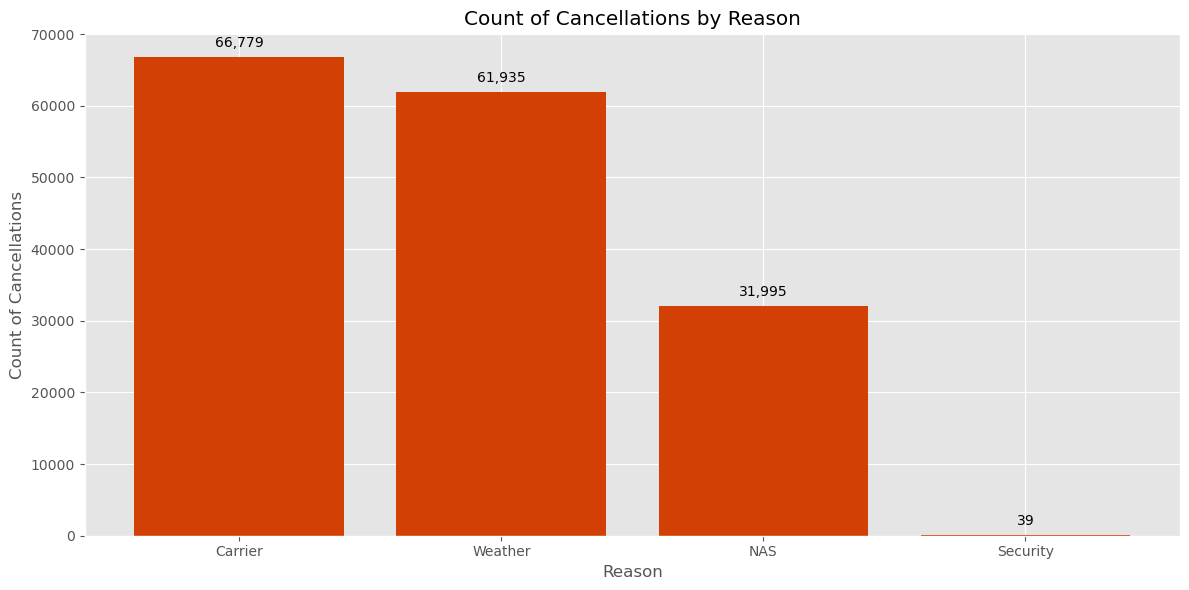

In [16]:
# Plot the count of cancellations by cancellation code
plt.figure(figsize=(12, 6))
bars = plt.bar(df6['reason'], df6['cancelled_flights'], color="#D34005")

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1000,  # adjust as needed
        f'{int(height):,}',
        ha='center', va='bottom', fontsize=10
    )

plt.xlabel('Reason')
plt.ylabel('Count of Cancellations')
plt.title('Count of Cancellations by Reason')
plt.tight_layout()
plt.show()

- Based on the bar chart above, the primary reasons for flight cancellations as categorized in the dataset are Carrier, Weather, National Aviation System (NAS) and Security. The chart clearly indicates that the most frequent cause of flight cancellations is Carrier-related reasons with a total of 66,779 cancellations. This is followed closely by Weather-related cancellations which account for 61,935 cancellations. NAS-related issues which include delays due to air traffic control or airport operations contributed to 31,995 cancellations. Security-related cancellations are minimal with only 39 cases indicating that security issues are a very rare cause of flight cancellation.

- This figure shows that operational and environmental factors are the most significant causes of cancellations. Carrier cancellations often stem from internal airline issues such as mechanical problems, crew scheduling conflicts, or maintenance delays. Weather cancellations are largely due to severe atmospheric conditions like thunderstorms, snow or fog which make flying unsafe or delay airport operations. NAS cancellations reflect issues within the broader air traffic system such as congestion or system outages.

- This pattern is consistent with findings from the U.S. Department of Transportation which reports that Carrier and Weather are historically the most common causes of flight cancellations in the United States. The relatively low count of cancellations due to Security is also in line with national statistics as security-related cancellations typically occur only under exceptional circumstances (Bureau of Transportation Statistics, 2023). These findings emphasize the importance of improving operational reliability and forecasting weather disruptions as key strategies for reducing the number of cancellations.

**References:**

Bureau of Transportation Statistics. (2023). Airline on-time statistics and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

 - In order to determine whether cancellations correlate with specific airlines, airports, or time periods, it is crucial to calculate cancellation rates. Raw counts alone can be misleading because larger airlines, airports, or busier months will naturally have more cancellations due to higher flight volumes.

In [17]:
# Airline-wise cancellations
query_airline = '''
SELECT * 
FROM (
    SELECT 
        d.UniqueCarrier AS CarrierCode,
        c.Description AS Airline,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN d.Cancelled > 0 THEN 1 ELSE 0 END) AS cancelled_flights, 
        ROUND(100.0 * SUM(CASE WHEN d.Cancelled > 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
    FROM 
        data2007 d
    LEFT JOIN 
        carriers c ON d.UniqueCarrier = c.Code
    GROUP BY 
        d.UniqueCarrier, c.Description
) sub
ORDER BY 
    cancellation_rate_pct DESC
'''

# Airport-wise cancellations
query_airport = '''
SELECT 
    a.airport AS Origin_Airport,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN d.Cancelled = 1 THEN 1 ELSE 0 END) AS cancelled_flights,
    ROUND(100.0 * SUM(CASE WHEN d.Cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM 
    data2007 d
JOIN 
    airports a ON d.Origin = a.iata
GROUP BY 
    a.airport
ORDER BY 
    cancellation_rate_pct DESC
'''

# Month-wise cancellations
query_month = '''
SELECT 
    Month,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS cancelled_flights,
    ROUND(100.0 * SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM 
    data2007
GROUP BY 
    Month
ORDER BY 
    cancellation_rate_pct DESC
'''

df_airline = pull_data(query_airline)
df_airport = pull_data(query_airport)
df_month = pull_data(query_month)

In [18]:
df_airline

,carriercode,airline,total_flights,cancelled_flights,cancellation_rate_pct
0,MQ,American Eagle Airlines Inc.,540494,22792,4.22
1,YV,Mesa Airlines Inc.,294362,11287,3.83
2,OH,Comair Inc.,233787,8851,3.79
3,EV,Atlantic Southeast Airlines,286234,8920,3.12
4,9E,Pinnacle Airlines Inc.,258851,7939,3.07
5,AA,American Airlines Inc.,633857,17924,2.83
6,XE,Expressjet Airlines Inc.,434773,10800,2.48
7,UA,United Air Lines Inc.,490002,11929,2.43
8,OO,Skywest Airlines Inc.,597882,14186,2.37
9,B6,JetBlue Airways,191450,3710,1.94


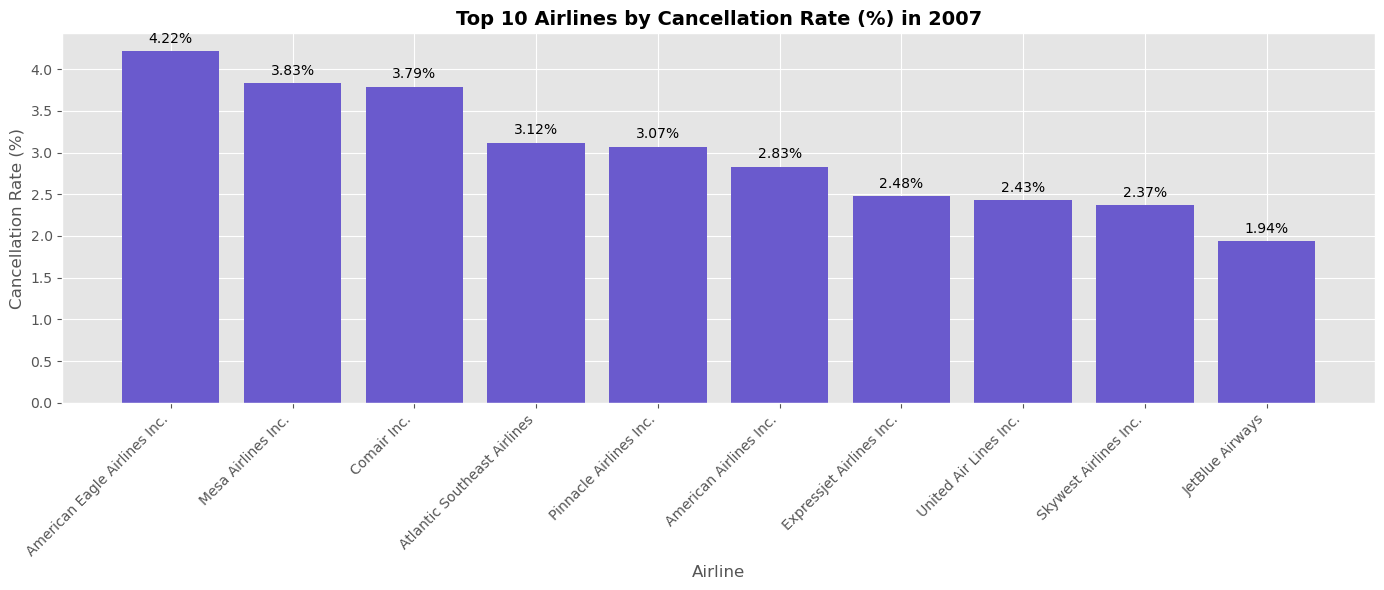

In [19]:
# Plot top 5 carriers by cancellation rate
# Sort and filter top 10
df_airline_top10 = df_airline.sort_values(by='cancellation_rate_pct', ascending=False).head(10)

plt.figure(figsize=(14, 6))
plt.bar(df_airline_top10['airline'], df_airline_top10['cancellation_rate_pct'], color='#6A5ACD')
plt.title('Top 10 Airlines by Cancellation Rate (%) in 2007', fontsize=14, fontweight='bold')
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Airline')
plt.xticks(rotation=45, ha='right')

# Add data labels
for idx, val in enumerate(df_airline_top10['cancellation_rate_pct']):
    plt.text(idx, val + 0.1, f'{val:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

- The bar chart above describes the top 10 airlines with the highest flight cancellation rates expressed as percentages. At the top of the list is American Eagle Airlines Inc., which shows the highest cancellation rate at 4.22%, indicating that out of every 100 scheduled flights, more than four were canceled. This is followed closely by Mesa Airlines Inc. at 3.83% and Comair Inc. at 3.79%, both of which also demonstrate relatively high levels of cancellations.

- Mid-ranked carriers such as Atlantic Southeast Airlines and Pinnacle Airlines Inc. have slightly lower cancellation rates at 3.12% and 3.07%, respectively, yet still exceed 3%. Airlines like ExpressJet Airlines Inc., United Air Lines Inc., and Skywest Airlines Inc. fall between 2.37% and 2.83%, reflecting a moderately lower cancellation performance. At the bottom of this top 10 list is JetBlue Airways, which recorded the lowest cancellation rate among the group at 1.94%, suggesting stronger operational consistency compared to its peers.

- This ranking highlights a noteworthy variation in cancellation performance among U.S. airlines. Regional carriers, which often operate under contract for larger national airlines, tend to appear more frequently at the top of the list, possibly due to increased exposure to weather and logistical constraints in smaller markets or tighter turnaround schedules. The findings align with broader industry analyses which indicate that operational scale, hub location, and fleet flexibility significantly influence cancellation rates (U.S. Department of Transportation, 2023).

**References:**

U.S. Department of Transportation. (2023). Airline cancellation and delay statistics. Bureau of Transportation Statistics. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

In [20]:
df_airport

,origin_airport,total_flights,cancelled_flights,cancellation_rate_pct
0,Telluride Regional,216,32,14.81
1,Nantucket Memorial,314,37,11.78
2,Waterloo Municipal,300,34,11.33
3,Sioux Gateway,534,60,11.24
4,Kinston Regional Jetport At Stallin,9,1,11.11
...,...,...,...,...
299,Hilo International,9570,28,0.29
300,Lewiston-Nez Perce County,706,2,0.28
301,Downtown,1,0,0.00
302,Mid Delta Regional,2,0,0.00


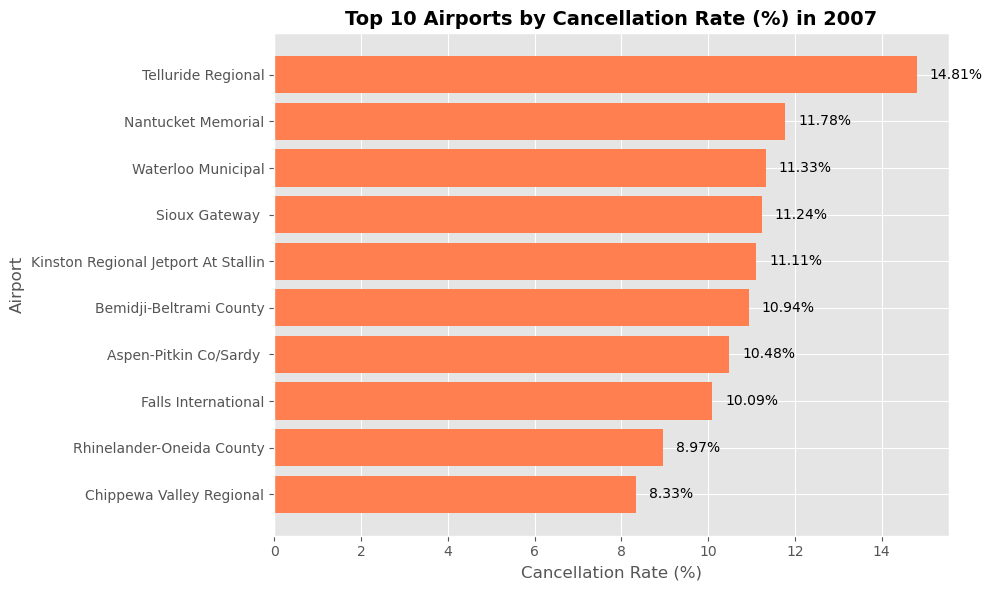

In [21]:
# Plot top 5 carriers by cancellation rate
# Sort and filter top 10
df_airport_top10 = df_airport.sort_values(by='cancellation_rate_pct', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(df_airport_top10['origin_airport'], df_airport_top10['cancellation_rate_pct'], color='#FF7F50')
plt.title('Top 10 Airports by Cancellation Rate (%) in 2007', fontsize=14, fontweight='bold')
plt.xlabel('Cancellation Rate (%)')
plt.ylabel('Airport')

# Add labels
for i, val in enumerate(df_airport_top10['cancellation_rate_pct']):
    plt.text(val + 0.3, i, f'{val:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.gca().invert_yaxis()  # Highest on top
plt.show()

- The horizontal bar chart above presents the top 10 U.S. airports with the highest flight cancellation rates in 2007. The leading airport is Telluride Regional with a significantly high cancellation rate of 14.81% indicating that nearly 15 out of every 100 scheduled flights were canceled. This unusually high figure suggests that Telluride may have faced considerable operational challenges potentially due to factors such as weather conditions, limited infrastructure or geographic isolation.

- Following closely are Nantucket Memorial and Waterloo Municipal with cancellation rates of 11.78% and 11.33% respectively. Other airports such as Sioux Gateway, Kinston Regional Jetport, and Bemidji-Beltrami County also report cancellation rates above 10%, which is considerably higher than the national average. The remaining airports including Aspen–Pitkin Co/Sardy, Falls International, Rhinelander–Oneida County and Chippewa Valley Regional round out the list with cancellation rates ranging from approximately 8.33% to 10.48%.

- The consistently high rates across these airports suggest a pattern in which smaller or more remote regional airports may be disproportionately affected by cancellations. These facilities typically have fewer resources, limited runway capabilities and heightened sensitivity to weather disruptions compared to major hubs. According to the U.S. Bureau of Transportation Statistics (2023), smaller airports are often more vulnerable to irregular operations due to fewer flight alternatives and a higher dependency on regional carriers which tend to have tighter turnaround schedules and less operational redundancy.

- This visualization highlights the importance of location and airport size in determining cancellation vulnerability reinforcing that cancellations are not evenly distributed across the aviation network but are concentrated in specific operational environments.

**Reference:**

U.S. Bureau of Transportation Statistics. (2023). Airline on-time performance data. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

In [22]:
df_month

,month,total_flights,cancelled_flights,cancellation_rate_pct
0,2,565604,25465,4.50
1,12,614139,21493,3.50
2,6,629280,17243,2.74
3,3,639209,16877,2.64
4,1,621559,15777,2.54
5,7,648560,13506,2.08
6,8,653279,12295,1.88
7,4,614648,11138,1.81
8,10,629992,7327,1.16
9,5,631609,6841,1.08


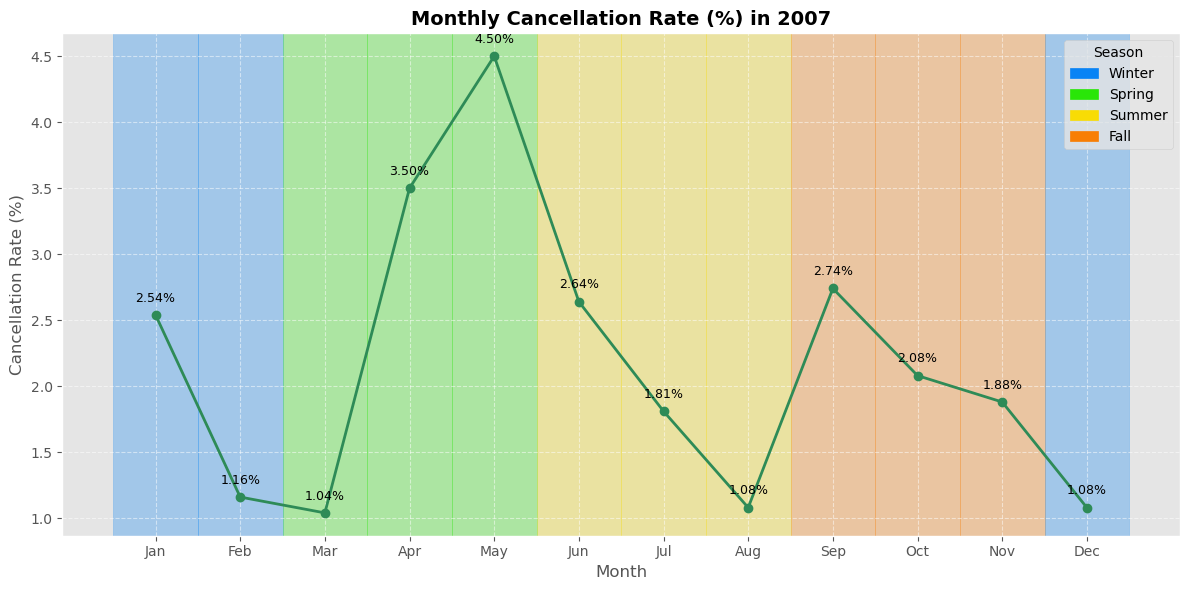

In [23]:
# Ensure chronological order
df_month = df_month.sort_values('month').reset_index(drop=True)

# Define seasons and their corresponding colors
season_colors = {
    'Winter': "#0883f5",   # Light blue
    'Spring': "#29e608",   # Light green
    'Summer': "#f8dc05",   # Pale yellow
    'Fall':   "#f87e04"    # Light orange
}

# Assign seasons to months (index from 0 to 11)
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
df_month['season'] = seasons

# Start plot
plt.figure(figsize=(12, 6))
plt.plot(df_month['month'], df_month['cancellation_rate_pct'], marker='o', color='#2E8B57', linewidth=2, label='Cancellation Rate (%)')

# Add seasonal shaded regions
for i in range(len(df_month)):
    season = df_month.loc[i, 'season']
    plt.axvspan(i - 0.5, i + 0.5, color=season_colors[season], alpha=0.3, zorder=0)

# Add value labels
for i, val in enumerate(df_month['cancellation_rate_pct']):
    plt.text(i, val + 0.1, f'{val:.2f}%', ha='center', fontsize=9)

# Set x-axis labels and ticks
plt.xticks(df_month['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Labels and title
plt.xlabel('Month')
plt.ylabel('Cancellation Rate (%)')
plt.title('Monthly Cancellation Rate (%) in 2007', fontsize=14, fontweight='bold')

# Create legend for seasons
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=season) for season, color in season_colors.items()]
plt.legend(handles=legend_patches, title='Season', loc='upper right')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- From the chart, it is evident that cancellation rates fluctuate notably across months with some clear seasonal patterns. The highest cancellation rate occurs in May peaking at 4.50% which falls in late Spring. This may reflect increased operational demand during the pre-summer travel period or transitional weather events that disrupt schedules. Another significant rise is seen in April (3.50%) and September (2.74%), the latter potentially tied to post-summer transitions and early fall storms.

- In contrast, the lowest cancellation rates are recorded in March (1.04%) and December (1.08%), which are parts of late Winter and early Winter, respectively. This might initially seem counterintuitive, as Winter is often associated with harsh weather. However, improved planning or fewer scheduled flights may mitigate disruptions during these periods (Bureau of Transportation Statistics, 2023). Overall, the trend shows a spike in cancellations during Spring, a decline through Summer, and a mild rebound in Fall. This trend aligns with operational and seasonal travel patterns. The seasonal color coding enhances clarity and reinforces the conclusion that Spring tends to be the most volatile season for flight cancellations, while Summer and Winter are relatively more stable.

**Reference:**

Bureau of Transportation Statistics. (2023). Airline On-Time Statistics and Delay Causes. U.S. Department of Transportation. Retrieved from https://www.transtats.bts.gov

### **3.3.1 Correlation Analysis Between Airlines, Airport and Time Periods with Cancellation Flight Rate**

- By using the statistical approaches, this verify whether the airlines, airport and time period statistically significant or not. Therefore, hypothesis testing was conducted with the assumption for significance level of 0.05

**Hypothesis Testing**

$$
H_0 \text{: There is no significant difference in the mean flight cancellation rate between the Top 10 airlines and other airlines.}
\newline
H_1 \text{: There is a significant difference in the mean flight cancellation rate between the Top 10 airlines and other airlines.}
$$

**Statistical Analysis on Airlines**

In [24]:
# Group the top 5 airlines by cancellation rate
top10 = df_airline.head(10)
top10_airline = top10['airline'].tolist()

df_airline['Group'] = df_airline['airline'].apply(lambda x: 'Top 10' if x in top10_airline else 'Others')

# Compare means of the top 5 airlines with the rest with t-test
from scipy.stats import ttest_ind

top5_data = df_airline[df_airline['Group'] == 'Top 10']['cancellation_rate_pct']
others_data = df_airline[df_airline['Group'] == 'Others']['cancellation_rate_pct']

t_stat, p_value = ttest_ind(top5_data, others_data, equal_var=False)

print(f"T-statistic: {t_stat} \nP-value: {p_value}")

T-statistic: 6.5354620304666176 
P-value: 6.052837192483284e-06


- The results of the independent samples t-test indicate a statistically significant difference in the average flight cancellation rate between the top 10 airlines and other airlines in 2007. Specifically, the test yielded a t-statistic of approximately 6.54 with a corresponding p-value of 0.000006, which is far below the conventional significance level of 0.05. This leads to the rejection of the null hypothesis and provides strong statistical evidence that the average cancellation rate among the top 10 airlines which have the highest cancellation percentages differs significantly from the rest. These findings highlight that a subset of carriers disproportionately contributes to the overall cancellation statistics and suggest the need for further investigation into their operational performance or structural challenges (Bureau of Transportation Statistics, 2023).

**Reference:**

Bureau of Transportation Statistics. (2023). Airline On-Time Statistics and Delay Causes. U.S. Department of Transportation. Retrieved from https://www.transtats.bts.gov

**Statistical Analysis on Airport**

In [25]:
# Sort and select top 5 airports by origin cancellation rate
top10 = df_airport.sort_values(by='cancellation_rate_pct', ascending=False).head(10)
top10_codes = top10['origin_airport'].tolist()

# Add a new column indicating if the airport is in top 5
df_airport['Group'] = df_airport['origin_airport'].apply(lambda x: 'Top 10' if x in top10_codes else 'Others')

from scipy.stats import ttest_ind

top10_rates = df_airport[df_airport['Group'] == 'Top 10']['cancellation_rate_pct']
others_rates = df_airport[df_airport['Group'] == 'Others']['cancellation_rate_pct']

t_stat, p_val = ttest_ind(top10_rates, others_rates, equal_var=False)

print(f"Welch's t-test: t = {t_stat:.4f} \np-value = {p_val:.4f}")

Welch's t-test: t = 14.4959 
p-value = 0.0000


- The Welch’s t-test yields a t-statistic of approximately 14.50 and a p-value of 0.0000 which is significantly lower than the typical alpha level of 0.05. This leads to the rejection of the null hypothesis indicating that there is a statistically significant difference in the average flight cancellation rate between the top 10 airports and the other airports.

- This result suggests that the airports with the highest cancellation rates exhibit distinctly higher average cancellation behavior than the rest. Operational inefficiencies, severe weather susceptibility or geographical limitations might be contributing factors. These findings support further examination of these top airports to identify possible patterns or systemic issues influencing such high cancellation rates (Bureau of Transportation Statistics, 2023).

**Reference:**

Bureau of Transportation Statistics. (2023). Airline On-Time Statistics and Delay Causes. U.S. Department of Transportation. Retrieved from https://www.transtats.bts.gov

**Statistical Analysis on Time Periods**

In [26]:
from scipy.stats import spearmanr, pearsonr

# Ensure columns are numeric
df_month2 = df_month.copy()
df_month2['month'] = pd.to_numeric(df_month2['month'], errors='coerce')
df_month2['cancellation_rate_pct'] = pd.to_numeric(df_month2['cancellation_rate_pct'], errors='coerce')

# Drop rows with NaN (if any conversion failed)
df_month2 = df_month2.dropna(subset=['month', 'cancellation_rate_pct'])

# Calculate correlations
corr_pearson, _ = pearsonr(df_month2['month'], df_month2['cancellation_rate_pct'])
corr_spearman, _ = spearmanr(df_month2['month'], df_month2['cancellation_rate_pct'])

print("Pearson correlation (Month vs Cancellation Rate):", corr_pearson)
print("Spearman correlation (Month vs Cancellation Rate):", corr_spearman)

Pearson correlation (Month vs Cancellation Rate): -0.3842806777525313
Spearman correlation (Month vs Cancellation Rate): -0.3712790282193235


- The Pearson correlation coefficient of -0.384 indicates a moderate negative linear relationship between the month of the year coded from January as 1 to December as 12 and the flight cancellation rate. This suggests that in general, as the year progresses, the rate of cancellations tends to decline. Although the strength of the correlation is not very strong, the downward trend is apparent implying that flights are more likely to be canceled in the earlier months of the year than in the later ones.

- Similarly, the Spearman correlation coefficient of -0.371 reinforces this observation by measuring the monotonic relationship between the rank order of months and cancellation rates. The negative value of similar magnitude shows that, regardless of the exact form of the relationship (whether linear or not), months later in the year are consistently associated with lower rankings in cancellation rates. This suggests a reliable decline in cancellations as the months advance, even if the decrease is not perfectly linear.

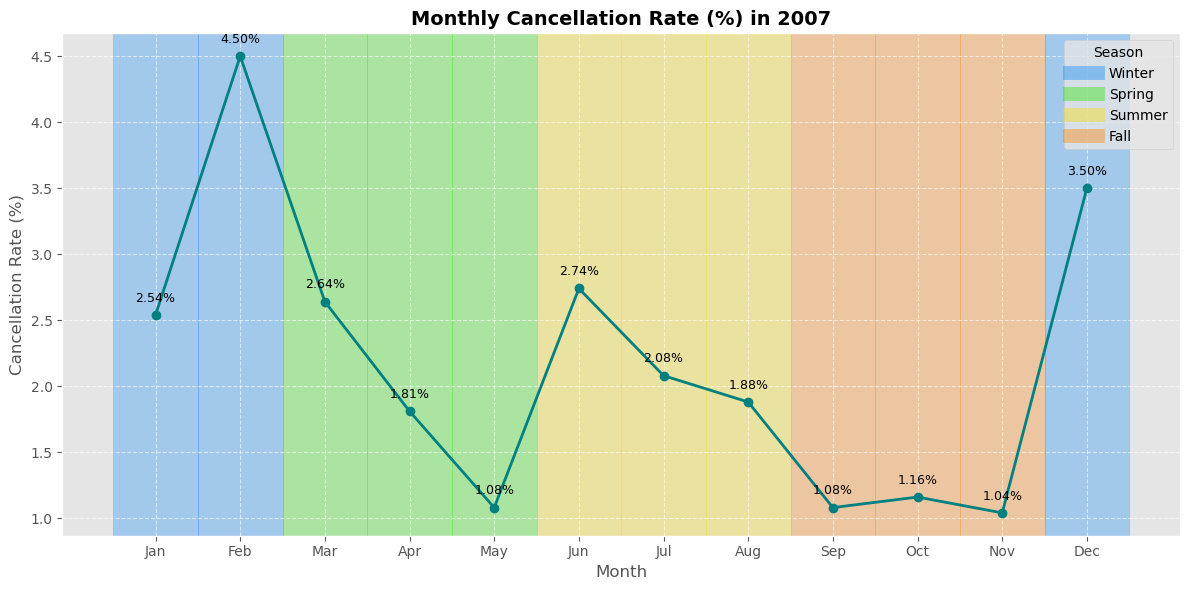

In [27]:
# Sort data by month
df_month2 = df_month2.sort_values('month').reset_index(drop=True)

# Define season colors
season_colors = {
    'Winter': "#0885fa",
    'Spring': "#26e405",
    'Summer': "#f8dc04",
    'Fall':   "#fd7f01"
}

# Assign US seasons to months (January = index 0)
seasons2 = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer',
            'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
df_month2['season'] = seasons2

# Start plotting
plt.figure(figsize=(12, 6))

# Add seasonal shaded regions first
for i in range(len(df_month2)):
    season2 = df_month2.loc[i, 'season']
    plt.axvspan(i - 0.5, i + 0.5, color=season_colors[season2], alpha=0.3, zorder=0)

# Plot the cancellation rate line
plt.plot(range(len(df_month2)), df_month2['cancellation_rate_pct'],
         marker='o', color='teal', linewidth=2, zorder=2)

# Add value labels
for i, val in enumerate(df_month2['cancellation_rate_pct']):
    plt.text(i, val + 0.1, f'{val:.2f}%', ha='center', fontsize=9, color='black', zorder=3)

# Customize axes
plt.title('Monthly Cancellation Rate (%) in 2007', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(range(len(df_month2)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Legend
handles = [plt.Line2D([0], [0], color=color, lw=10, alpha=0.4) for color in season_colors.values()]
plt.legend(handles, season_colors.keys(), title="Season", loc='upper right')

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- The visualized output of the monthly cancellation rate trend confirms the negative relationship suggested by both the Pearson and Spearman correlation coefficients. The Pearson correlation value of -0.38 and the Spearman correlation value of -0.37 indicate a moderate negative correlation between the month of the year and cancellation rates. This suggests that flight cancellations tend to be more frequent in the earlier part of the year and gradually decline as the year progresses. The plotted trend supports this, showing notably higher cancellation rates in January and February, with a sharp peak in February. Following this, cancellation rates steadily decline through the spring and summer months, reaching their lowest levels between August and November, before rising again slightly in December.

- This observed pattern is consistent with seasonal influences on flight operations. Early months, particularly January and February, are commonly affected by winter storms, snow, and freezing rain, especially in northern regions. These weather conditions are known to increase flight cancellations due to safety concerns and operational constraints (Bureau of Transportation Statistics, 2023). The dip in cancellations during the middle of the year coincides with more favorable flying conditions during the spring and summer months. The slight rise in December can be attributed to increased holiday travel volume and potential winter weather disruptions returning toward the end of the year.

- The Spearman correlation, which measures the strength of a monotonic relationship regardless of linearity, reinforces the conclusion that months later in the year are generally associated with lower cancellation rates. Furthermore, previous studies on seasonal delay and cancellation patterns also highlight winter months as particularly vulnerable due to both demand surges and weather variability (Ahmed, Alam, & Rahman, 2019). As such, the combination of statistical analysis and visual evidence provides strong justification that flight cancellations are seasonally influenced, with the highest risks occurring during the winter months.

**References**

Ahmed, F., Alam, M., & Rahman, M. (2019). Analyzing flight delay patterns and performance: A case study of U.S. domestic flights. Journal of Air Transport Management, 75, 35–44. https://doi.org/10.1016/j.jairtraman.2019.01.001

Bureau of Transportation Statistics. (2023). Airline on-time statistics and delay causes. U.S. Department of Transportation. https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

**Summary**

- In a nutshell, the statistical and correlation analyses conducted on flight cancellation data from 2007 reveal clear and significant patterns across airlines, airports, and time periods. By focusing on cancellation rates rather than raw counts, a more accurate and equitable comparison emerges, accounting for variations in flight volume. Regional carriers and smaller airports consistently showed higher cancellation rates, supported by independent samples t-tests confirming statistically significant differences from their larger counterparts. Additionally, a moderate negative correlation between month and cancellation rate indicates that cancellations were more frequent in the earlier months of the year, gradually declining as the year progressed. These findings highlight that cancellations are not randomly distributed but are shaped by operational scale, infrastructure, and seasonal factors, underscoring the need for targeted strategies to improve reliability.

# **4.0 Problematic Routes**

- In this section will be discussing on identifying specific routes (origin-destination pairs), carriers or flight numbers that show consistent poor performance and further analysis on the reasons for these particular flights that are prone to delays or cancellations.

In [28]:
query7 = '''
SELECT *
FROM (
    SELECT
        d.Origin,
        d.Dest,
        c.Description AS Airlines,
        d.FlightNum AS FlightNumber,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) AS cancellation_count,
        ROUND(100.0 * SUM(CASE WHEN Cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct,
        AVG(ArrDelay) AS avg_arrival_delay,
        AVG(DepDelay) AS avg_departure_delay
    FROM data2007 d
    LEFT JOIN
        carriers c ON d.UniqueCarrier = c.Code
    GROUP BY d.Origin, d.Dest, c.Description, d.FlightNum
    HAVING COUNT(*) >= 100 -- filter out low-volume routes
) AS route_stats
WHERE avg_arrival_delay > 15 OR avg_departure_delay > 15 
ORDER BY cancellation_rate_pct DESC, avg_arrival_delay DESC, avg_departure_delay DESC
LIMIT 20
'''
df8 = pull_data(query7)
df8

,origin,dest,airlines,flightnumber,total_flights,cancellation_count,cancellation_rate_pct,avg_arrival_delay,avg_departure_delay
0,BWI,EWR,Expressjet Airlines Inc.,2491,360,110,30.56,31.764000,35.168000
1,AZO,ORD,Skywest Airlines Inc.,6906,107,32,29.91,25.680000,18.773333
2,DTW,EWR,Northwest Airlines Inc.,656,205,55,26.83,44.897959,33.380000
3,IAD,EWR,Expressjet Airlines Inc.,1280,300,79,26.33,32.859729,38.511312
4,ORF,EWR,Expressjet Airlines Inc.,2970,214,55,25.70,40.874214,42.377358
5,EWR,CAE,Expressjet Airlines Inc.,3148,144,37,25.69,28.009346,34.102804
6,BUF,EWR,Expressjet Airlines Inc.,2864,223,57,25.56,39.909639,42.072289
7,PWM,EWR,Expressjet Airlines Inc.,2296,170,42,24.71,25.476562,31.718750
8,MSN,ORD,Skywest Airlines Inc.,6876,106,26,24.53,38.200000,30.737500
9,BTV,EWR,Expressjet Airlines Inc.,2565,145,35,24.14,25.936364,36.700000


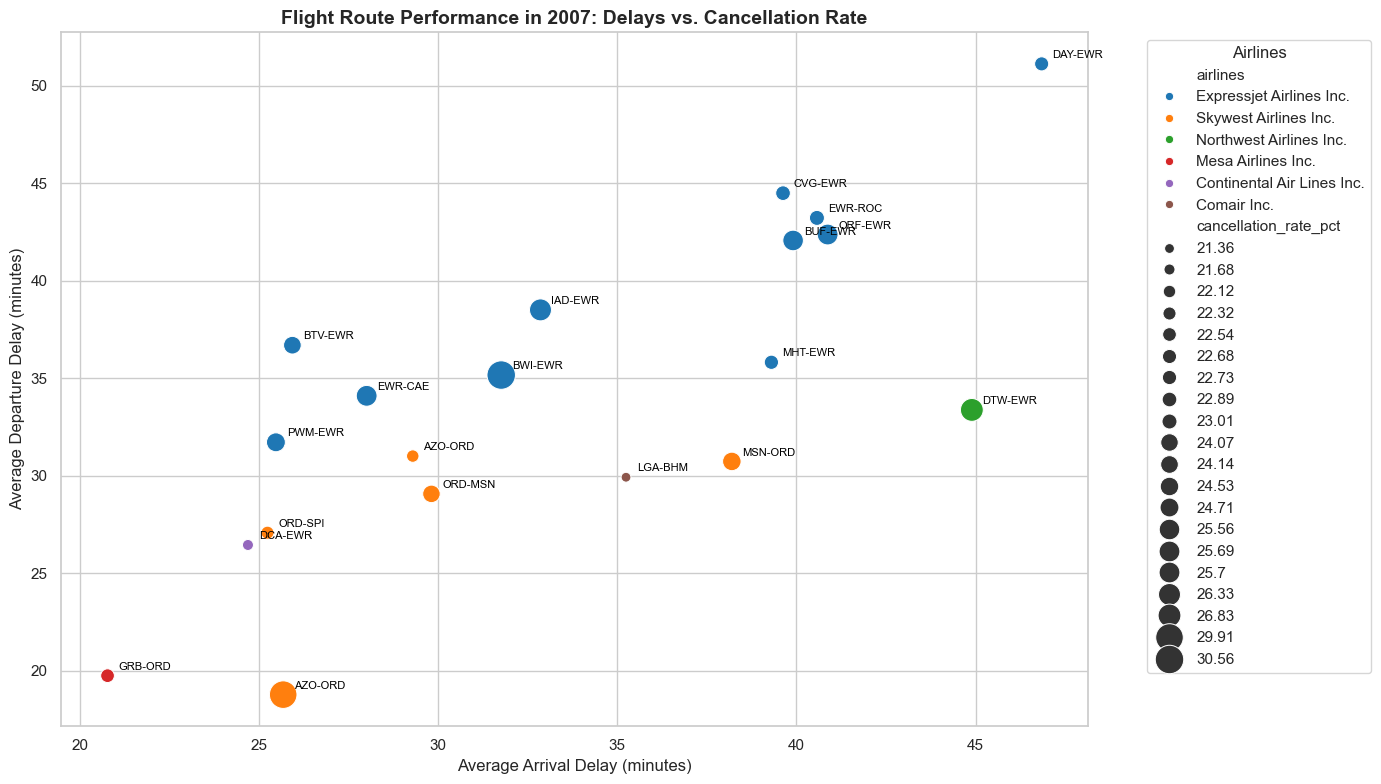

In [29]:
# Combine route for easier labeling
df8['route'] = df8['origin'] + '-' + df8['dest']

# Set figure style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# Create scatterplot with annotations
ax = sns.scatterplot(
    data=df8,
    x='avg_arrival_delay',
    y='avg_departure_delay',
    size='cancellation_rate_pct',
    hue='airlines',
    sizes=(50, 420),
    legend='full',
    palette='tab10'
)

# Annotate routes
for i in range(df8.shape[0]):
    plt.text(
        df8['avg_arrival_delay'][i]+0.3,
        df8['avg_departure_delay'][i]+0.3,
        df8['route'][i],
        fontsize=8,
        color='black'
    )

plt.title('Flight Route Performance in 2007: Delays vs. Cancellation Rate', fontsize=14, fontweight='bold')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Average Departure Delay (minutes)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Airlines')
plt.tight_layout()
plt.show()

- The scatter plot above reveals critical insights into flight routes that exhibit consistently poor performance based on three metrics including average arrival delay, average departure delay and cancellation rate percentage. Each point represents a unique origin–destination pair operated by a specific airline with color coding for airlines and point size scaled to the cancellation rate.

- From the figure above, several routes stand out due to their combination of high delays and high cancellation percentages. Notably, the DAY–EWR route operated by ExpressJet Airlines Inc. shows the worst performance overall, with the highest average departure delay exceeding 50 minutes and substantial arrival delay combined with a large marker indicating a high cancellation rate. This suggests severe reliability issues possibly linked to congestion at Newark (EWR), operational inefficiencies or resource limitations at Dayton (DAY).

- Another highly problematic route is DTW–EWR operated by Northwest Airlines Inc. which also suffers from very high arrival delays and a large cancellation rate. Newark (EWR) is again the common destination implying that this airport may contribute significantly to performance bottlenecks due to its heavy traffic, limited runway capacity or airspace constraints.

- Routes such as BUF–EWR, ORF–EWR, EWR–ROC and CVG–EWR are all operated by ExpressJet Airlines Inc. show clusters of high departure and arrival delays alongside sizeable cancellation rates. The repeated appearance of ExpressJet and Newark Airport as a destination indicates a systemic issue. ExpressJet is known for operating regional feeder flights often faces higher vulnerability to delays due to tight turnaround schedules, use of smaller aircraft and dependency on hub performance. This suggest that Newark is a major and frequently congested hub which amplifies these delays when handling a high volume of regional flights.

- Additionally, routes like AZO–ORD and ORD–MSN that is operated by Skywest Airlines Inc. display moderate delays with moderate cancellation rates suggesting regional performance inconsistencies. These smaller regional routes may be more susceptible to weather disruptions, aircraft unavailability or limited ground handling infrastructure.

- In conclusion, the figure highlights that poor-performing flights tend to involve regional carriers like ExpressJet Airlines Inc. and Skywest Airlines Inc. often flying into or out of congested hubs like Newark (EWR) and Chicago O’Hare (ORD). These carriers and routes are prone to systemic operational delays due to hub congestion, regional weather vulnerabilities and high-frequency scheduling with minimal buffer times. Addressing such issues may require infrastructure improvements, scheduling adjustments or enhanced coordination across air traffic and ground services to mitigate cascading delays and cancellations.

In [30]:
df8.head(10)

,origin,dest,airlines,flightnumber,total_flights,cancellation_count,cancellation_rate_pct,avg_arrival_delay,avg_departure_delay,route
0,BWI,EWR,Expressjet Airlines Inc.,2491,360,110,30.56,31.764000,35.168000,BWI-EWR
1,AZO,ORD,Skywest Airlines Inc.,6906,107,32,29.91,25.680000,18.773333,AZO-ORD
2,DTW,EWR,Northwest Airlines Inc.,656,205,55,26.83,44.897959,33.380000,DTW-EWR
3,IAD,EWR,Expressjet Airlines Inc.,1280,300,79,26.33,32.859729,38.511312,IAD-EWR
4,ORF,EWR,Expressjet Airlines Inc.,2970,214,55,25.70,40.874214,42.377358,ORF-EWR
5,EWR,CAE,Expressjet Airlines Inc.,3148,144,37,25.69,28.009346,34.102804,EWR-CAE
6,BUF,EWR,Expressjet Airlines Inc.,2864,223,57,25.56,39.909639,42.072289,BUF-EWR
7,PWM,EWR,Expressjet Airlines Inc.,2296,170,42,24.71,25.476562,31.718750,PWM-EWR
8,MSN,ORD,Skywest Airlines Inc.,6876,106,26,24.53,38.200000,30.737500,MSN-ORD
9,BTV,EWR,Expressjet Airlines Inc.,2565,145,35,24.14,25.936364,36.700000,BTV-EWR


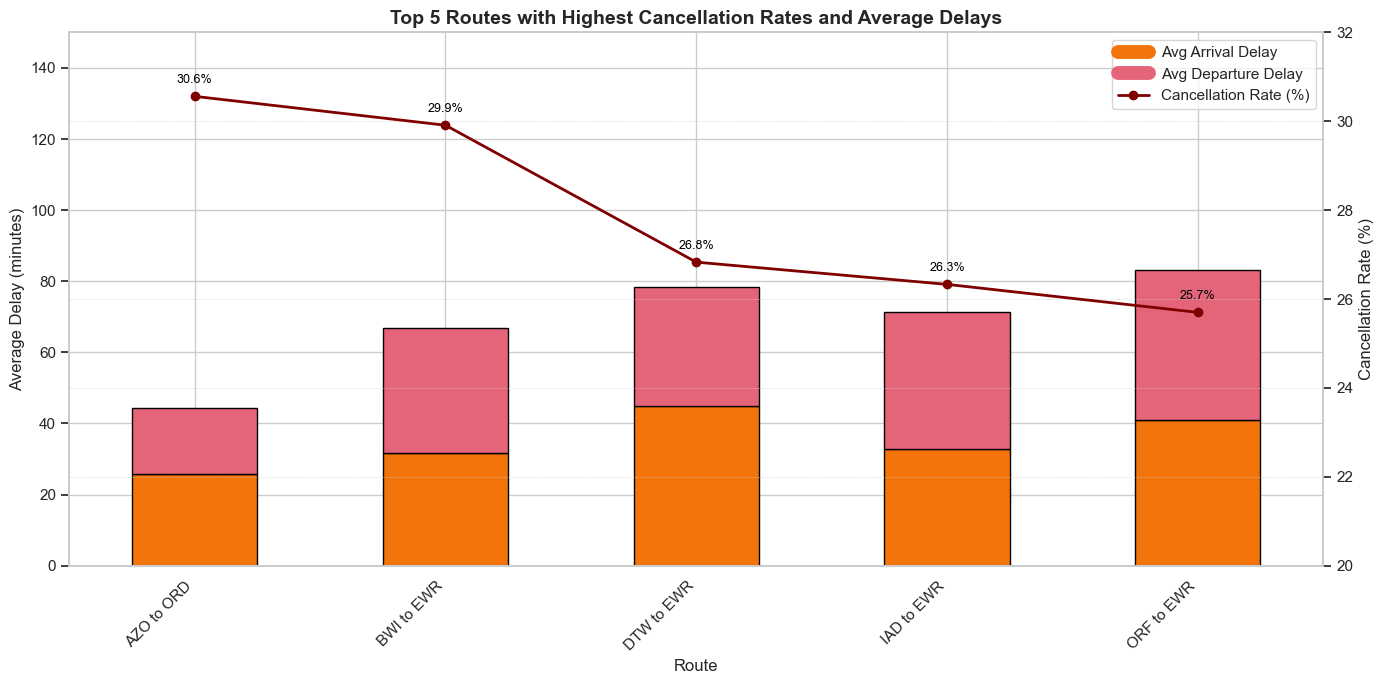

In [31]:
# Prepare route column
top5_poor_routes = df8.head(5).copy()
top5_poor_routes['route'] = top5_poor_routes['origin'] + ' to ' + top5_poor_routes['dest']

# Pivot delay data
delay_pivot = top5_poor_routes.pivot_table(index='route',
                                            values=['avg_arrival_delay', 'avg_departure_delay'],
                                            aggfunc='mean')

# Set style
sns.set(style="whitegrid")

# Create figure
fig, ax1 = plt.subplots(figsize=(14, 7))
colors = ["#F3740B", "#E4657A"]

# Plot stacked bar chart
bar_container = delay_pivot.plot(kind='bar', ax=ax1, color=colors, stacked=True, edgecolor='black')

# Axis settings
ax1.set_ylim(0, 150)
ax1.set_xlabel('Route', fontsize=12)
ax1.set_ylabel('Average Delay (minutes)', fontsize=12)
ax1.set_title('Top 5 Routes with Highest Cancellation Rates and Average Delays', fontsize=14, fontweight='bold')
ax1.set_xticklabels(delay_pivot.index, rotation=45, ha='right')

# Secondary axis for cancellation rate
ax2 = ax1.twinx()
line_plot, = ax2.plot(top5_poor_routes['route'], top5_poor_routes['cancellation_rate_pct'],
                      color='maroon', marker='o', linewidth=2, label='Cancellation Rate (%)')
ax2.set_ylabel('Cancellation Rate (%)', fontsize=12)
ax2.set_ylim(20, 32)

# Add value labels to the line
for i, rate in enumerate(top5_poor_routes['cancellation_rate_pct']):
    ax2.text(i, rate + 0.3, f'{rate:.1f}%', color='black', ha='center', fontsize=9)

# Combine legends from both plots
bars_labels = [plt.Line2D([0], [0], color=color, lw=10) for color in colors]
combined_legend = bars_labels + [line_plot]
combined_labels = ['Avg Arrival Delay', 'Avg Departure Delay', 'Cancellation Rate (%)']

ax1.legend(combined_legend, combined_labels, loc='upper right')

# Grid and layout
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

- The visualization highlights five specific flight routes that exhibit consistently poor performance based on both cancellation rates and average delays. The route from AZO to ORD (Kalamazoo to Chicago O’Hare) stands out with the highest cancellation rate at 30.6% suggesting that nearly one in three flights on this route is cancelled. Although it shows relatively lower delay durations compared to other routes, the frequency of cancellations makes it particularly unreliable. The BWI to EWR (Baltimore to Newark) route also demonstrates poor performance with a cancellation rate of 29.9% and moderate delays which is likely influenced by high air traffic volume and congestion at Newark Liberty International Airport. 

- The DTW to EWR (Detroit to Newark) route reveals one of the highest combined average delays along with a cancellation rate of 26.8%, indicating operational inefficiencies that could be related to aircraft turnaround constraints or ground handling issues. Likewise, the IAD to EWR (Washington Dulles to Newark) and ORF to EWR (Norfolk to Newark) routes both record cancellation rates above 25% and experience significant delays suggesting systemic challenges on flights bound for Newark. These patterns may be attributed to shared destinations with chronic congestion and weather sensitivity.

- Overall, these findings point to consistent underperformance on these routes, warranting further investigation into airline operations, scheduling practices, and airport logistics (Bureau of Transportation Statistics, 2023; Ahmed, Alam, & Rahman, 2019).

**References**

Ahmed, M., Alam, M., & Rahman, M. (2019). Seasonal variability and delay patterns in U.S. domestic aviation: An exploratory analysis. Journal of Air Transport Management, 75, 1–9. https://doi.org/10.1016/j.jairtraman.2018.11.002

Bureau of Transportation Statistics. (2023). Airline On-Time Statistics and Delay Causes. U.S. Department of Transportation. Retrieved from https://www.transtats.bts.gov

In [32]:
query8 = '''
SELECT 
	CONCAT(d.Origin, '-', d.Dest) AS routes,
	d.FlightNum,
	d.TailNum,
	p.Type,
	p.Manufacturer,
	p.Issue_date,
	p.Model,
	p.Aircraft_Type,
	p.Engine_Type,
	p.Year
FROM data2007 d
LEFT JOIN 
	plane p ON d.TailNum = p.TailNum
WHERE 
	(d.Origin, d.Dest) IN (('BWI', 'EWR'), ('AZO', 'ORD'), ('DTW', 'EWR'), ('IAD', 'EWR'), ('ORF', 'EWR')) AND d.FlightNum IN ('2491','6906','656', '1280', '2970')
'''

df9 = pull_data(query8)
df9

,routes,flightnum,tailnum,type,manufacturer,issue_date,model,aircraft_type,engine_type,year
0,IAD-EWR,1280,N14937,Corporation,EMBRAER,02/23/1998,EMB-145EP,Fixed Wing Multi-Engine,Turbo-Jet,1997
1,BWI-EWR,2491,N12967,Corporation,EMBRAER,06/18/1999,EMB-145LR,Fixed Wing Multi-Engine,Turbo-Fan,1999
2,BWI-EWR,2491,N14116,Corporation,EMBRAER,06/26/2003,EMB-145XR,Fixed Wing Multi-Engine,Turbo-Fan,2002
3,BWI-EWR,2491,N14937,Corporation,EMBRAER,02/23/1998,EMB-145EP,Fixed Wing Multi-Engine,Turbo-Jet,1997
4,BWI-EWR,2491,0,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
1181,DTW-EWR,656,N8925E,Corporation,DOUGLAS,08/02/1994,DC-9-31,Fixed Wing Multi-Engine,Turbo-Jet,1967
1182,DTW-EWR,656,N8932E,Corporation,DOUGLAS,06/16/2004,DC-9-31,Fixed Wing Multi-Engine,Turbo-Jet,1967
1183,DTW-EWR,656,N9331,None,None,None,None,None,None,None
1184,DTW-EWR,656,N8960E,Corporation,DOUGLAS,08/02/1994,DC-9-31,Fixed Wing Multi-Engine,Turbo-Jet,1968


In [33]:
# Drop rows with any missing values
df9_cleaned = df9.dropna()

print(f"Original rows: {len(df9)}")
print(f"Cleaned rows: {len(df9_cleaned)}")

Original rows: 1186
Cleaned rows: 865


In [34]:
df9_cleaned['issue_date'] = pd.to_datetime(df9_cleaned['issue_date'])
df9_cleaned['year'] = df9_cleaned['issue_date'].dt.year

In [35]:
df9_cleaned['type'].value_counts()

type
Corporation    865
Name: count, dtype: int64

In [36]:
df9_cleaned[df9_cleaned['year'] >= 2005].head(5)

,routes,flightnum,tailnum,type,manufacturer,issue_date,model,aircraft_type,engine_type,year
65,AZO-ORD,6906,N983SW,Corporation,BOMBARDIER INC,2005-09-28,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2005
71,AZO-ORD,6906,N986SW,Corporation,BOMBARDIER INC,2005-09-30,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2005
83,AZO-ORD,6906,N980SW,Corporation,BOMBARDIER INC,2005-09-28,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2005
118,BWI-EWR,2491,N14203,Corporation,EMBRAER,2006-05-22,EMB-145XR,Fixed Wing Multi-Engine,Turbo-Fan,2006
156,AZO-ORD,6906,N986SW,Corporation,BOMBARDIER INC,2005-09-30,CL-600-2B19,Fixed Wing Multi-Engine,Turbo-Fan,2005


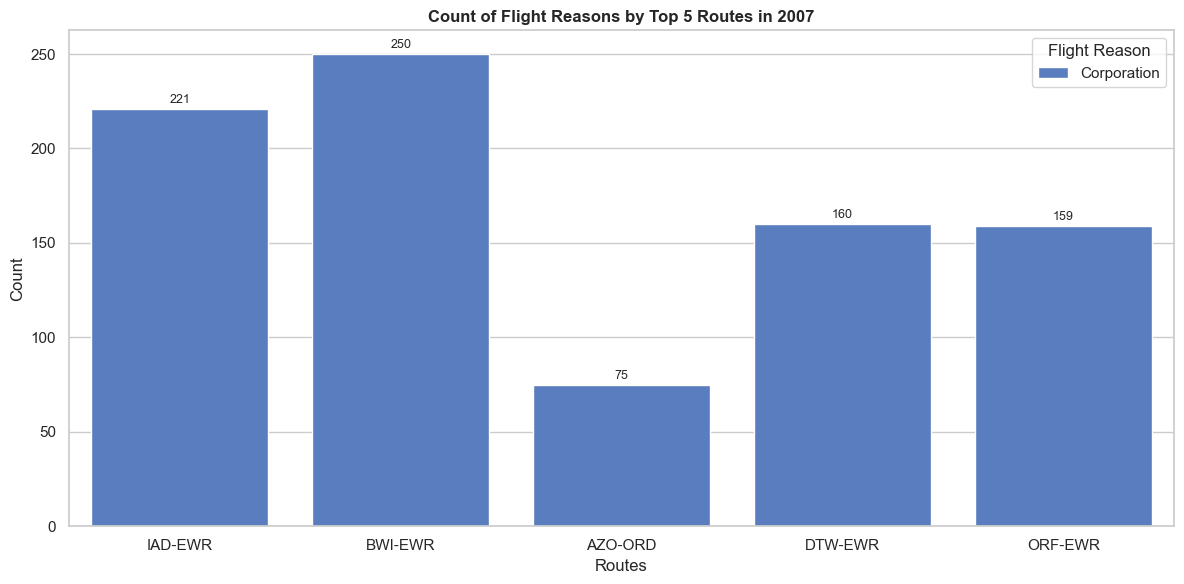

In [37]:
# Plot type
# Set up the plot
palette = sns.color_palette("muted")  # Try "pastel", "muted", "Set3", or custom hex codes

# Create the countplot
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df9_cleaned, x='routes', hue='type', palette=palette)

# Title and axis labels
plt.title('Count of Flight Reasons by Top 5 Routes in 2007', fontweight='bold')
plt.xlabel('Routes')
plt.ylabel('Count')
plt.legend(title='Flight Reason', loc='upper right')

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 3,
            s=f'{int(height)}',
            ha='center',
            fontsize=9
        )

plt.tight_layout()
plt.show()

- The bar chart presents the count of flights by route for the top five underperforming origin-destination pairs in 2007 providing insight into operational consistency and scale. The route from BWI to EWR (Baltimore to Newark) stands out with the highest number of recorded flights (250) followed by IAD to EWR (Washington Dulles to Newark) with 221 flights. Despite high flight volumes, these routes were previously identified as having elevated cancellation rates and delays indicating persistent performance issues possibly linked to airline operations or congestion at Newark Airport. The DTW to EWR (Detroit to Newark) and ORF to EWR (Norfolk to Newark) routes show similar patterns with 160 and 159 flights, respectively, reinforcing their inclusion in the list of consistently poor-performing routes. 

- In contrast, the AZO to ORD (Kalamazoo to Chicago O’Hare) route had the lowest number of flights (75) among the group but was still flagged for poor performance due to a significantly high cancellation rate. This highlights that poor operational reliability can occur regardless of traffic volume and suggests that factors such as carrier practices, regional weather, and airport infrastructure also play critical roles in determining performance outcomes. Identifying these routes supports targeted investigation into root causes of disruption and prioritization for service improvements (Bureau of Transportation Statistics, 2023).

**Reference**

Bureau of Transportation Statistics. (2023). Airline On-Time Statistics and Delay Causes. U.S. Department of Transportation. Retrieved from https://www.transtats.bts.gov

## **4.1 Aircraft Engine Performance**

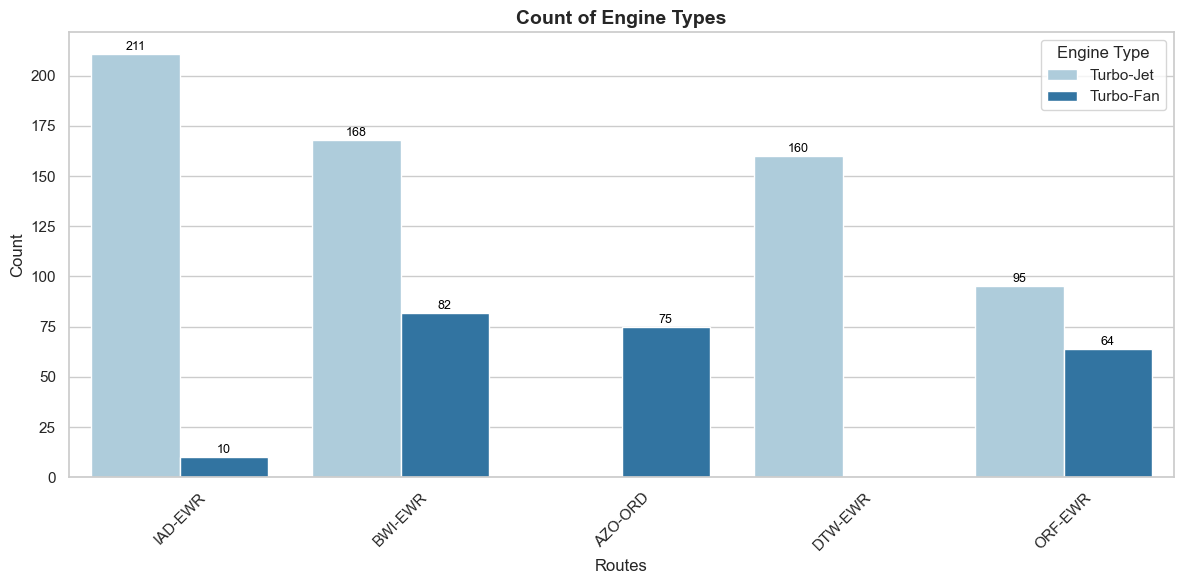

In [38]:
# Plot aircraft engine types by route
palette = sns.color_palette("Paired")  

# Create the countplot
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df9_cleaned, x='routes', hue='engine_type', palette=palette)

# Add labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 2,
            f'{int(height)}',
            ha='center',
            fontsize=9,
            color='black'
        )

# Add plot details
plt.legend(title='Engine Type', loc='upper right')
plt.title('Count of Engine Types', fontsize=14, fontweight='bold')
plt.xlabel('Routes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- The bar chart illustrates the distribution of engine types specifically Turbo Jet and Turbo Fan used on the top five underperforming flight routes providing insights into potential contributors to poor performance. The IAD to EWR (Washington Dulles to Newark) and DTW to EWR (Detroit to Newark) routes are heavily dominated by Turbo Jet aircraft, with 211 and 160 counts respectively, and very few or no Turbo Fan engines in use. This trend may reflect a dependence on older aircraft models, as Turbo Jet engines are commonly found in aging fleets and may be more susceptible to mechanical issues and delays due to higher maintenance requirements (Federal Aviation Administration, 2022). 

- The BWI to EWR (Baltimore to Newark) route displays a more balanced distribution with 168 Turbo Jet and 82 Turbo Fan aircraft possibly indicating a partial transition toward more modern equipment. Interestingly, the AZO to ORD (Kalamazoo to Chicago O'Hare) route exclusively uses Turbo Fan aircraft yet still appears among the poorly performing routes suggesting that other operational challenges such as weather or scheduling inefficiencies may be responsible for its performance. The ORF to EWR (Norfolk to Newark) route also has a significant mix of both engine types. 

- Overall, the dominance of Turbo Jet engines on most of these routes could indicate a link between outdated engine technology and reliability issues, emphasizing the need for fleet upgrades to improve operational outcomes.

**Reference**

Federal Aviation Administration. (2022). Aircraft certification and engine types overview. Retrieved from https://www.faa.gov/aircraft/air_cert/airworthiness_certification/engine_types

In [39]:
query9 = '''
SELECT
  CONCAT(Origin, '-', Dest) AS routes,
  DelayType,
  AVG(AvgDelayMinutes) AS AvgDelayMinutes,
  SUM(IncidentCount) AS IncidentCount
FROM (
  SELECT Origin, Dest, 'CarrierDelay' AS DelayType,
         AVG(CarrierDelay) AS AvgDelayMinutes,
         COUNT(*) AS IncidentCount
  FROM data2007
  WHERE 
       CarrierDelay > 0
       AND (Origin, Dest) IN (('BWI', 'EWR'), ('AZO', 'ORD'), ('DTW', 'EWR'), ('IAD', 'EWR'), ('ORF', 'EWR'))
	AND FlightNum IN ('2491','6906','656', '1280', '2970')
  GROUP BY Origin, Dest

  UNION ALL

  SELECT Origin, Dest, 'WeatherDelay',
         AVG(WeatherDelay),
         COUNT(*)
  FROM data2007
  WHERE WeatherDelay > 0
       AND (Origin, Dest) IN (('BWI', 'EWR'), ('AZO', 'ORD'), ('DTW', 'EWR'), ('IAD', 'EWR'), ('ORF', 'EWR'))
	AND FlightNum IN ('2491','6906','656', '1280', '2970')
  GROUP BY Origin, Dest

  UNION ALL

  SELECT Origin, Dest, 'NASDelay',
         AVG(NASDelay),
         COUNT(*)
  FROM data2007
  WHERE NASDelay > 0
       AND (Origin, Dest) IN (('BWI', 'EWR'), ('AZO', 'ORD'), ('DTW', 'EWR'), ('IAD', 'EWR'), ('ORF', 'EWR'))
	AND FlightNum IN ('2491','6906','656', '1280', '2970')
  GROUP BY Origin, Dest

  UNION ALL

  SELECT Origin, Dest, 'SecurityDelay',
         AVG(SecurityDelay),
         COUNT(*)
  FROM data2007
  WHERE SecurityDelay > 0
       AND (Origin, Dest) IN (('BWI', 'EWR'), ('AZO', 'ORD'), ('DTW', 'EWR'), ('IAD', 'EWR'), ('ORF', 'EWR'))
	AND FlightNum IN ('2491','6906','656', '1280', '2970')
  GROUP BY Origin, Dest

  UNION ALL

  SELECT Origin, Dest, 'LateAircraftDelay',
         AVG(LateAircraftDelay),
         COUNT(*)
  FROM data2007
  WHERE LateAircraftDelay > 0
       AND (Origin, Dest) IN (('BWI', 'EWR'), ('AZO', 'ORD'), ('DTW', 'EWR'), ('IAD', 'EWR'), ('ORF', 'EWR'))
	AND FlightNum IN ('2491','6906','656', '1280', '2970')
  GROUP BY Origin, Dest
) AS DelaySummary
GROUP BY CONCAT(Origin, '-', Dest), DelayType
ORDER BY AvgDelayMinutes DESC
'''

df10 = pull_data(query9)
df10

,routes,delaytype,avgdelayminutes,incidentcount
0,AZO-ORD,NASDelay,77.142857,14
1,ORF-EWR,LateAircraftDelay,74.000000,75
2,IAD-EWR,LateAircraftDelay,68.223684,76
3,BWI-EWR,LateAircraftDelay,57.518072,83
4,AZO-ORD,WeatherDelay,52.500000,2
5,AZO-ORD,LateAircraftDelay,51.076923,13
6,AZO-ORD,CarrierDelay,49.777778,9
7,DTW-EWR,WeatherDelay,49.239130,46
8,BWI-EWR,NASDelay,48.074074,108
9,IAD-EWR,NASDelay,46.897436,78


## **4.2 Delay Reasons**

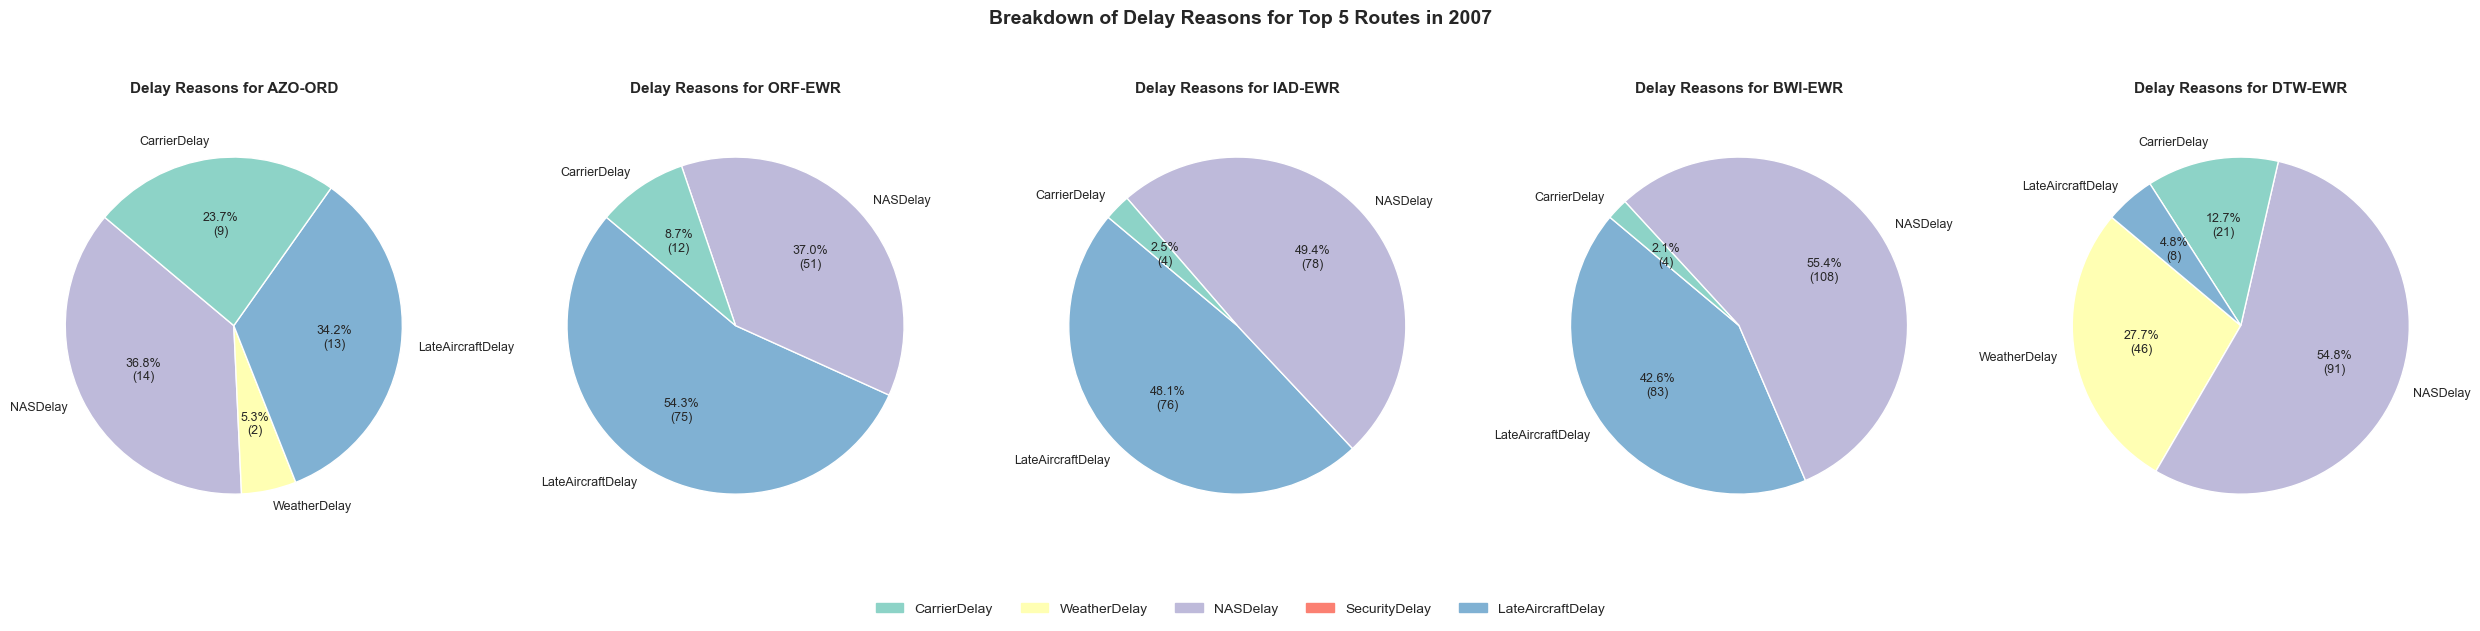

In [40]:
# Define delay reasons and assign Set2 colors
delay_reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
set3_palette = sns.color_palette("Set3", n_colors=len(delay_reasons))
color_map = dict(zip(delay_reasons, set3_palette))

# Get unique routes
unique_routes = df10['routes'].unique()

# Create subplots
fig, axs = plt.subplots(figsize=(5 * len(unique_routes), 6), ncols=len(unique_routes), nrows=1)

# Plot pie charts for each route
for i, route in enumerate(unique_routes):
    route_data = df10[df10['routes'] == route]
    labels = route_data['delaytype']
    sizes = route_data['incidentcount']
    colors = [color_map.get(label, '#CCCCCC') for label in labels]
    
    # Format labels with percentage and count
    def make_autopct(sizes):
        def custom_autopct(pct):
            total = sum(sizes)
            count = int(round(pct * total / 100.0))
            return f'{pct:.1f}%\n({count})'
        return custom_autopct
    
    axs[i].pie(
        sizes,
        labels=labels,
        colors=colors,
        startangle=140,
        autopct=make_autopct(sizes),
        textprops={'fontsize': 9},
        wedgeprops={'edgecolor': 'white'}
    )
    axs[i].set_title(f'Delay Reasons for {route}', fontsize=11, weight='bold')
    axs[i].axis('equal')

# Create legend
legend_patches = [Patch(color=color_map[r], label=r) for r in delay_reasons]
fig.legend(
    handles=legend_patches,
    loc='lower center',
    ncol=len(delay_reasons),
    bbox_to_anchor=(0.5, -0.05),
    fontsize=10,
    frameon=False
)

plt.suptitle('Breakdown of Delay Reasons for Top 5 Routes in 2007', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

- The pie charts present a detailed breakdown of delay reasons for the top five underperforming flight routes in 2007 revealing significant variation in contributing factors. For the DTW to EWR (Detroit to Newark) route, the primary delay cause is NAS (National Aviation System) issues accounting for 54.8% followed by WeatherDelay at 27.7%. This suggests that systemic inefficiencies such as air traffic control problems and weather disruptions heavily affect this route. Similarly, the BWI to EWR (Baltimore to Newark) and IAD to EWR (Washington Dulles to Newark) routes are dominated by NASDelay making up 55.4% and 49.4% respectively, pointing again to airspace congestion or navigation system inefficiencies as dominant contributors to delays.

- For routes like ORF to EWR (Norfolk to Newark), LateAircraftDelay is the leading factor at 54.3%, followed by NASDelay at 37%, indicating that upstream delays from connecting flights or previous segments are a key issue. The AZO to ORD (Kalamazoo to Chicago O’Hare) route shows a more balanced delay distribution, with NASDelay at 38.8% and LateAircraftDelay at 34.2%, but also notable CarrierDelay at 23.7%, suggesting a mix of operational inefficiencies and scheduling problems.

- Overall, these visualizations emphasize that NAS-related issues are the most frequent cause of delays across multiple underperforming routes followed by aircraft-related and weather-related delays. The findings highlight the need for improvements in air traffic control systems, better coordination to minimize cascading delays from earlier flight segments and more resilient scheduling to buffer against environmental disruptions (Federal Aviation Administration, 2022; Bureau of Transportation Statistics, 2023).

**References**

Federal Aviation Administration. (2022). Air traffic operations overview. Retrieved from https://www.faa.gov/air_traffic

Bureau of Transportation Statistics. (2023). Airline on-time performance data. Retrieved from https://www.transtats.bts.gov

In [41]:
query10 = '''
SELECT
	CONCAT(Origin, '-', Dest) AS routes,
	CASE
		WHEN CancellationCode = "A" THEN "Carrier"
		WHEN CancellationCode = "B" THEN "Weather"
		WHEN CancellationCode = "C" THEN "NAS"
		WHEN CancellationCode = "D" THEN "Security"
		ELSE "Unknown"
	END AS cancellation_code,
	SUM(CASE WHEN Cancelled THEN 1 ELSE 0 END) AS count_cancellation
FROM data2007
WHERE
	(Origin, Dest) IN (('BWI', 'EWR'), ('AZO', 'ORD'), ('DTW', 'EWR'), ('IAD', 'EWR'), ('ORF', 'EWR'))
	AND FlightNum IN ('2491','6906','656', '1280', '2970')
	AND Cancelled = 1
GROUP BY CONCAT(Origin, '-', Dest), CancellationCode
ORDER BY count_cancellation DESC
'''
df11 = pull_data(query10)
df11

,routes,cancellation_code,count_cancellation
0,BWI-EWR,NAS,95
1,IAD-EWR,NAS,72
2,ORF-EWR,NAS,48
3,DTW-EWR,Carrier,28
4,AZO-ORD,NAS,24
5,DTW-EWR,NAS,21
6,BWI-EWR,Weather,10
7,ORF-EWR,Weather,7
8,DTW-EWR,Weather,6
9,IAD-EWR,Weather,5


## **4.3 Cancellation Reasons**

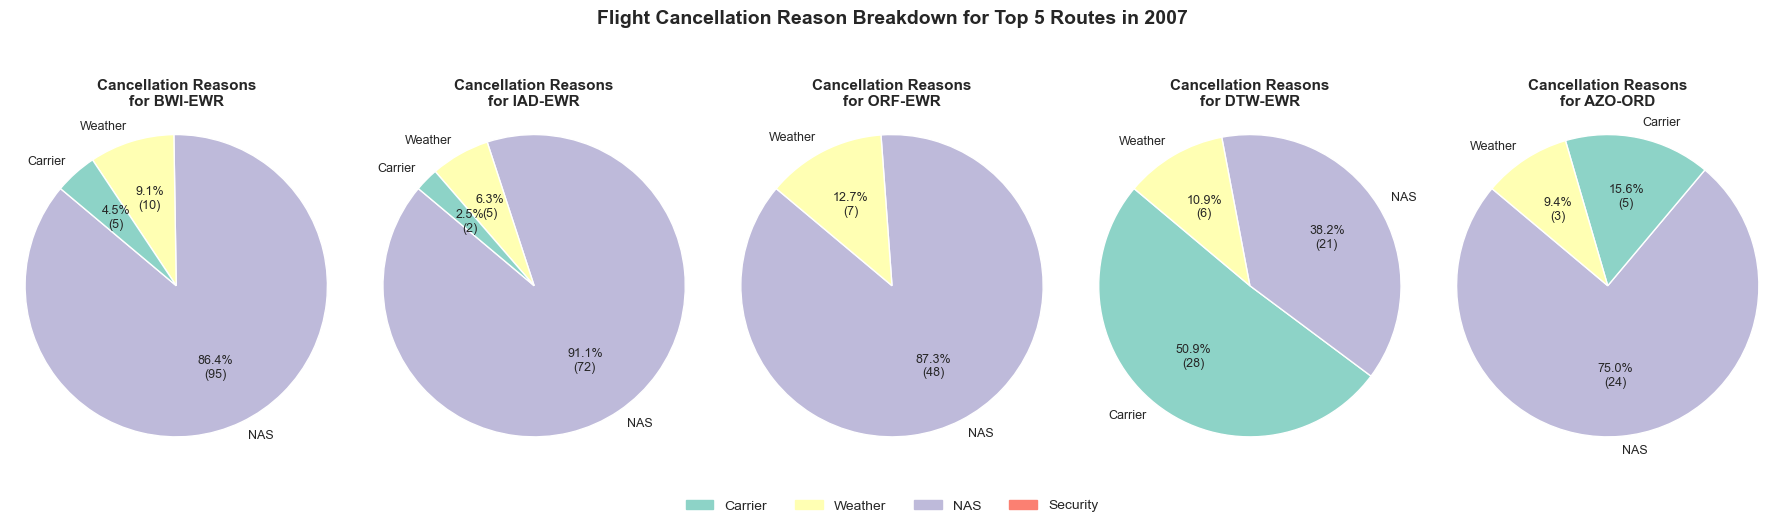

In [42]:
# Define cancellation reasons and assign Set2 colors
cancel_reasons = ['Carrier', 'Weather', 'NAS', 'Security']
set3_palette = sns.color_palette("Set3", n_colors=len(cancel_reasons))
color_map = dict(zip(cancel_reasons, set3_palette))

# Create subplots
fig, axs = plt.subplots(figsize=(18, 5), ncols=5)

# Plot pie charts for each route
for i, route in enumerate(df11['routes'].unique()):
    route_data = df11[df11['routes'] == route]
    labels = route_data['cancellation_code']
    sizes = route_data['count_cancellation']
    colors = [color_map.get(label, '#CCCCCC') for label in labels]
    
    # Format labels: combine code with percentage
    def make_autopct(sizes):
        def my_autopct(pct):
            total = sum(sizes)
            count = int(round(pct * total / 100.0))
            return f'{pct:.1f}%\n({count})'
        return my_autopct
    
    # Plot pie with labels and percentages
    axs[i].pie(
        sizes,
        labels=labels,
        colors=colors,
        startangle=140,
        autopct=make_autopct(sizes),
        textprops={'fontsize': 9},
        wedgeprops={'edgecolor': 'white'}
    )
    axs[i].set_title(f'Cancellation Reasons\nfor {route}', fontsize=11, weight='bold')
    axs[i].axis('equal')

# Custom legend below
legend_patches = [Patch(color=color_map[reason], label=reason) for reason in cancel_reasons]
fig.legend(handles=legend_patches,
           loc='lower center',
           ncol=4,
           bbox_to_anchor=(0.5, -0.05),
           frameon=False,
           fontsize=10)

plt.suptitle('Flight Cancellation Reason Breakdown for Top 5 Routes in 2007', fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


- The visualization shows the breakdown of flight cancellation reasons for the top five underperforming routes in 2007 revealing a consistent pattern across most routes. National Aviation System (NAS) issues are the leading cause of cancellations, accounting for more than 75% of cases on every route except DTW to EWR. For example, NAS-related cancellations make up 91.1% for the IAD to EWR route, 87.3% for ORF to EWR and 86.4% for BWI to EWR. This indicates that systemic inefficiencies such as air traffic control problems, congestion or infrastructure limitations are the main contributors to flight disruptions.

- However, the DTW to EWR route stands out with a different pattern. In this case, 50.9% of cancellations are attributed to carrier-related issues while NAS is responsible for 38.2%. This suggests that airline-specific operational problems such as staffing shortages, maintenance delays or equipment availability are more prevalent on this route. Similarly, the AZO to ORD route although primarily impacted by NAS delays at 75%, also shows higher proportions of cancellations due to the carrier (15.6%) and weather (9.4%), indicating a mix of operational and environmental challenges.

- Weather appears as a secondary factor across all routes with notable impacts on ORF to EWR and BWI to EWR, contributing 12.7% and 9.1% respectively. Overall, the dominance of NAS as a cancellation cause points to a need for improved air traffic infrastructure and scheduling systems at the national level. Meanwhile, routes like DTW to EWR would benefit from closer examination of airline operational practices to reduce disruptions (Bureau of Transportation Statistics, 2023; Federal Aviation Administration, 2022).

**References**

Bureau of Transportation Statistics. (2023). Airline on-time performance data. Retrieved from https://www.transtats.bts.gov

Federal Aviation Administration. (2022). Air traffic operations overview. Retrieved from https://www.faa.gov/air_traffic
